In [1]:
%matplotlib inline


# Visualizing spike sorting results

In this code waveforms of the units identified by the spike sorting are extracted and different metrics of quality are calculated to determine what are the good clusters to keep. There is code to visualize units and their waveforms, ISI and SNR


In [2]:
import os
import glob
from pathlib import Path
from collections import defaultdict
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd

In [3]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [4]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [5]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [6]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [7]:
import spikeinterface.full as si

In [8]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 0: Importing Processes Recording and Spike Sorting Data from Previous Notebook

- We want the processed recording file from the previous notebook and not the raw file because we added information about the probes used and filtered it in different ways

# NOTE: You must change the input directory if you are using your own processed files

In [132]:
# This is the folder that has all your processed files
input_dir = "./proc/recording_extractor/"

In [136]:
raw_recording_files = glob.glob(os.path.join(input_dir, "*", "raw_recording"))

In [137]:
raw_recording_files=".proc/recording_extractor/raw_recording" #the previous line couldnt find the raw_recording

In [138]:
if len(raw_recording_files) == 1:
    raw_recording = spikeinterface.core.load_extractor(file_or_folder_or_dict=raw_recording_files[0])
elif len(raw_recording_files) >= 2:
    raise ValueError("There is more than one recording file: {}".format(raw_recording_files))
else: 
    raise ValueError("There is no recording file: {}".format(input_dir))

ValueError: There is more than one recording file: .proc/recording_extractor/raw_recording

In [12]:
processed_recording_files = glob.glob(os.path.join(input_dir, "*", "processed_recording"))

In [131]:
processed_recording_files[0]

'./proc/02172021_BLA4-1_3_Competition_Rec/processed_recording'

In [13]:
if len(processed_recording_files) == 1:
    common_reference_recording = spikeinterface.core.load_extractor(file_or_folder_or_dict=processed_recording_files[0])
elif len(processed_recording_files) >= 2:
    raise ValueError("There is more than one recording file: {}".format(processed_recording_files))
else: 
    raise ValueError("There is no recording file: {}".format(input_dir))

- Importing the Spike Sorting Output

In [15]:
spike_sorting_files = glob.glob(os.path.join(input_dir, "*", "spikesorting_output"))

In [16]:
if len(spike_sorting_files) == 1:
    spike_sorted_object = ss.read_sorter_folder(spike_sorting_files[0])
elif len(spike_sorting_files) >= 2:
    raise ValueError("There is more than one spikesorting folder: {}".format(spike_sorting_files))
else: 
    raise ValueError("There is no recording file: {}".format(input_dir))

# Part 1: Post Processing

- Different resources to look at for Post Processing
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_2_postprocessing.html
    - https://github.com/SpikeInterface/spiketutorials/blob/master/Official_Tutorial_SI_0.90_Aug2021/SpikeInterface_Tutorial.ipynb
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_3_quality_mertics.html
    - https://catalystneuro.github.io/spike-sorting-hackathon/

## Extracting Waveforms

In [17]:
from spikeinterface import WaveformExtractor, extract_waveforms
import spikeinterface.extractors as se

- The WaveformExtractor class:
    - randomly samples a subset spikes with max_spikes_per_unit
    - extracts all waveforms snippets for each unit
    - saves waveforms in a local folder
    - can load stored waveforms
    - retrieves template (average or median waveform) for each unit
    - https://spikeinterface.readthedocs.io/en/latest/modules/core/plot_4_waveform_extractor.html



- Extracting waveforms from preprocessed recordings and spike sorted output from Mountainsort 
    - Based on Maya's settings in recoreded video 
    - Saving to folder

# NOTE: If you are using a different directory for your files that outputted from the files you are inputting, then you must change the directory path

In [129]:
path = Path(spike_sorting_files[0])
print(path.parent.absolute())

/nancy/user/riwata/projects/spike_sorting/jupyter_notebooks/proc/02172021_BLA4-1_3_Competition_Rec


In [19]:
spike_sorting_files

['./proc/02172021_BLA4-1_3_Competition_Rec/spikesorting_output']

In [128]:
waveform_output_dir

'/nancy/user/riwata/projects/spike_sorting/jupyter_notebooks/proc/02172021_BLA4-1_3_Competition_Rec/waveform_output'

In [20]:
spikesorting_output_dir = Path(spike_sorting_files[0])
output_dir = spikesorting_output_dir.parent.absolute()
waveform_output_dir = os.path.join(output_dir, "waveform_output")

In [78]:
we_mountainsort = si.extract_waveforms(recording=common_reference_recording, 
                                       sorting=spike_sorted_object, folder=waveform_output_dir,
                                      ms_before=1, ms_after=1, progress_bar=True,
                                      n_jobs=8, total_memory="1G", overwrite=True,
                                       max_spikes_per_unit=2000)

extract waveforms: 100%|#############################| 32/32 [00:11<00:00,  2.85it/s]


- Loading from folder

In [21]:
we_mountainsort = WaveformExtractor.load_from_folder(waveform_output_dir)

In [23]:
si.extract_waveforms??

## Signal to Noise Ratio of Each Unit

- Calculating Signal to Noise Ratio

In [22]:
we_mountainsort

WaveformExtractor: 32 channels - 83 units - 1 segments
  before:20 after20 n_per_units: 2000

In [23]:
we_ms4_signal_to_noise = st.compute_snrs(we_mountainsort).values()

In [24]:
we_ms4_signal_to_noise

dict_values([0.22266676, 3.9103994, 3.5818481, 0.0141862575, 3.6831605, 0.19408226, 4.606358, 7.0485744, 3.7418382, 0.48312184, 4.7676406, 4.1380477, 4.0287113, 4.570964, 0.18060249, 4.54056, 0.32044187, 4.950304, 3.5823667, 11.098004, 4.1378045, 3.560929, 15.520291, 0.51715654, 3.5598896, 5.8258896, 0.5105747, 4.969575, 2.2673209, 53.31505, 58.204624, 2.9850776, 5.784382, 4.6440406, 2.5786033, 11.152628, 5.455341, 2.69305, 15.384119, 1.0465889, 5.4431186, 5.391763, 1.0516477, 88.56519, 82.33858, 5.105143, 0.6364125, 6.562615, 18.2427, 8.825368, 4.911492, 0.03842606, 4.3792057, 3.7568767, 0.11455258, 4.6552176, 10.213422, 1.0103105, 5.6550303, 0.32494548, 3.808402, 0.6401005, 9.729538, 8.286657, 19.3792, 6.433818, 7.6159167, 6.9274073, 3.7321532, 4.493529, 9.723977, 0.4421347, 3.955093, 10.357663, 5.9144764, 11.881687, 5.093701, 24.393433, 21.406467, 5.1096325, 3.7937083, 0.19412315, 3.8375158])

In [27]:
len(we_ms4_signal_to_noise)

83

- Filtering the Units that have higher signal to noise ratios

(array([21., 38.,  7.,  6.,  1.,  2.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.]),
 array([1.41862575e-02, 2.96588659e+00, 5.91758680e+00, 8.86928654e+00,
        1.18209867e+01, 1.47726870e+01, 1.77243881e+01, 2.06760883e+01,
        2.36277885e+01, 2.65794888e+01, 2.95311890e+01, 3.24828873e+01,
        3.54345894e+01, 3.83862877e+01, 4.13379898e+01, 4.42896881e+01,
        4.72413902e+01, 5.01930885e+01, 5.31447906e+01, 5.60964890e+01,
        5.90481911e+01, 6.19998894e+01, 6.49515915e+01, 6.79032898e+01,
        7.08549881e+01, 7.38066940e+01, 7.67583923e+01, 7.97100906e+01,
        8.26617889e+01, 8.56134949e+01, 8.85651932e+01], dtype=float32),
 <BarContainer object of 30 artists>)

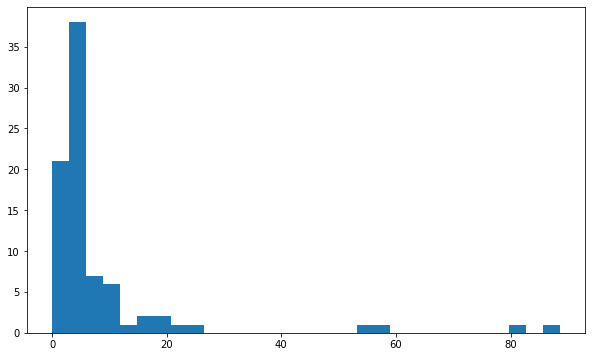

In [28]:
plt.hist(we_ms4_signal_to_noise, bins=30)

- Creating a mask based on whether the SNR ratio is higher than what we specified

In [25]:
mask = np.array(list(we_ms4_signal_to_noise)) > 5

In [26]:
mask

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False,  True, False,
       False, False,  True,  True, False,  True, False, False,  True,
        True, False,  True, False,  True,  True, False,  True,  True,
        True, False,  True,  True,  True, False, False, False, False,
       False, False,  True, False,  True, False, False, False,  True,
        True,  True,  True,  True,  True, False, False,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False, False])

In [27]:
spike_sorted_object.get_unit_ids()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

- We will get a list of all the Unit IDs that have higher SNR ratios based on the indexes of these units in the mask

In [28]:
high_snr_units = spike_sorted_object.get_unit_ids()[mask]

In [29]:
high_snr_units

array([ 8, 20, 23, 26, 30, 31, 33, 36, 37, 39, 41, 42, 44, 45, 46, 48, 49,
       50, 57, 59, 63, 64, 65, 66, 67, 68, 71, 74, 75, 76, 77, 78, 79, 80])

In [30]:
len(spike_sorted_object.get_unit_ids()[mask])

34

## Plotting the Waveforms for a single unit

- Each column represents a single channel
    - We are plotting the units with the highest signal to noise ratio

In [80]:
we_mountainsort

WaveformExtractor: 32 channels - 83 units - 1 segments
  before:20 after20 n_per_units: 2000

- TODO: Change X ticks so that they correspond to channel ID's

/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/spikeinterface/widgets/basewidget.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.figure = plt.figure()


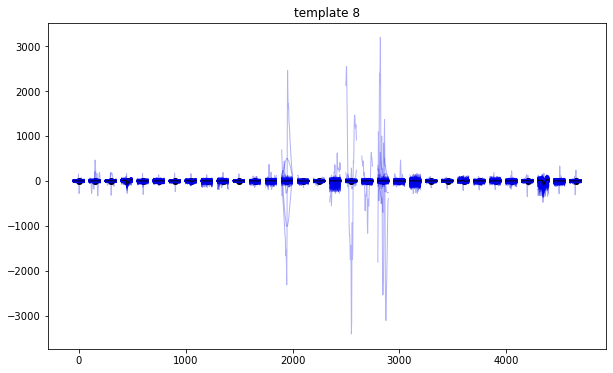

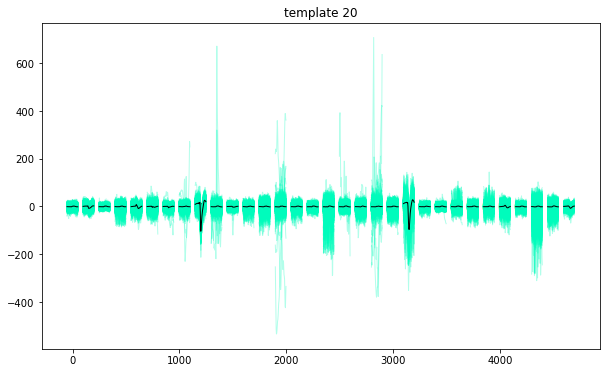

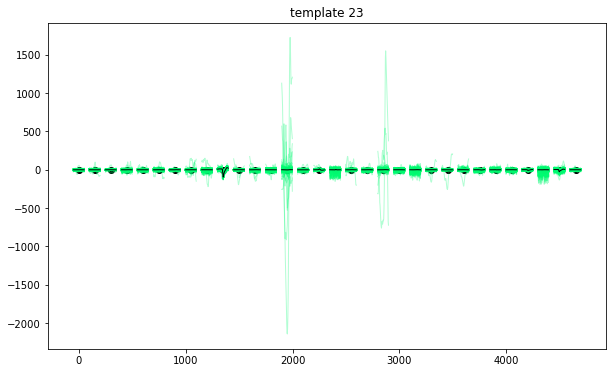

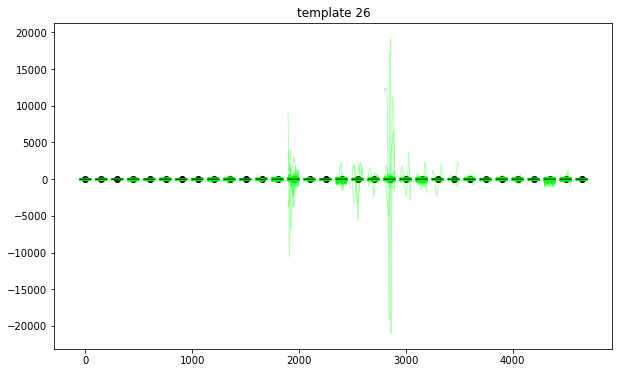

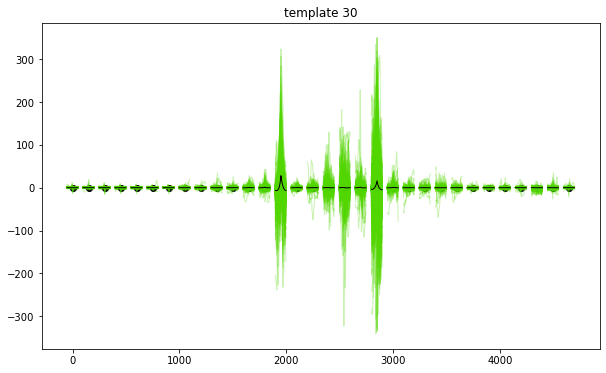

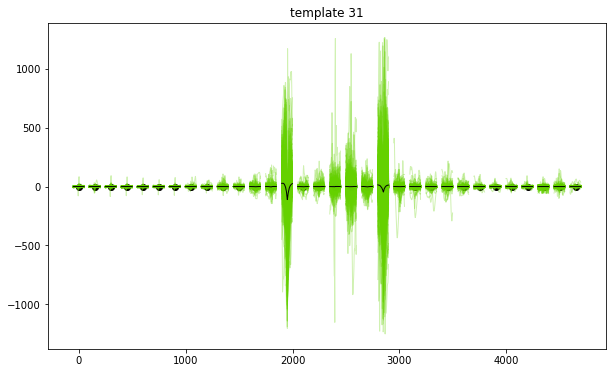

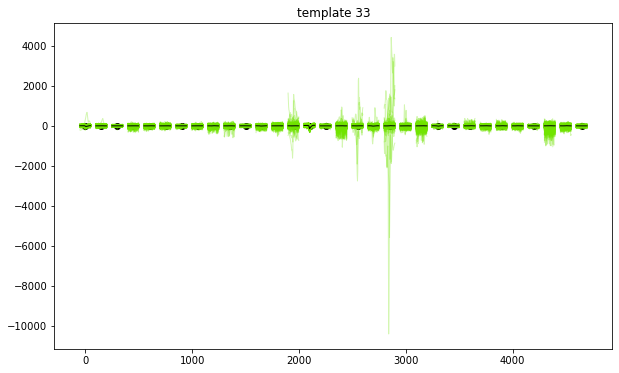

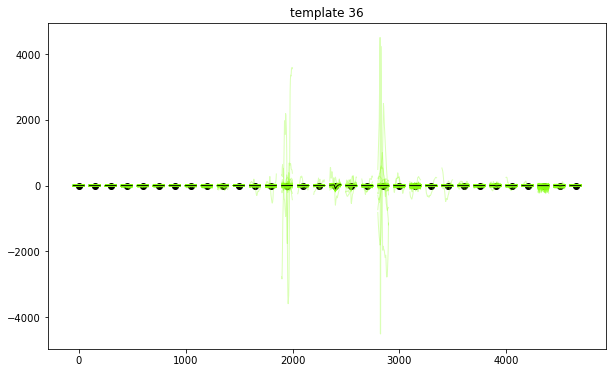

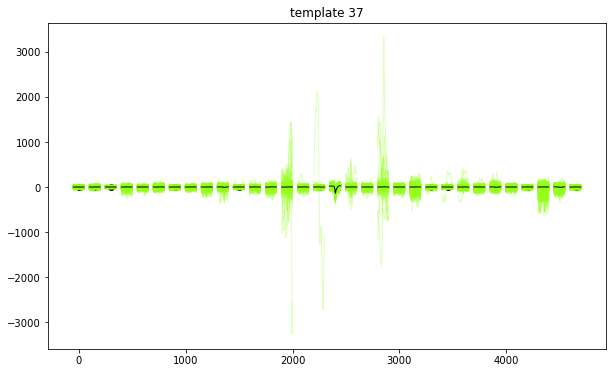

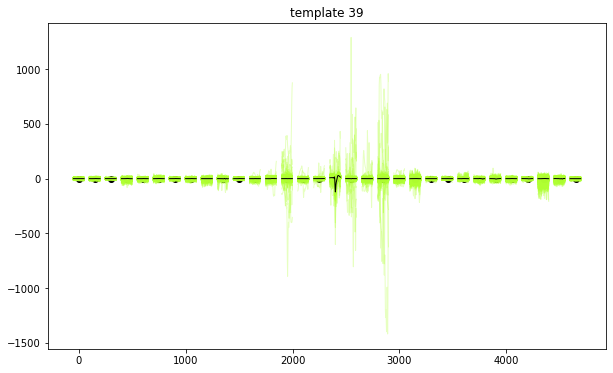

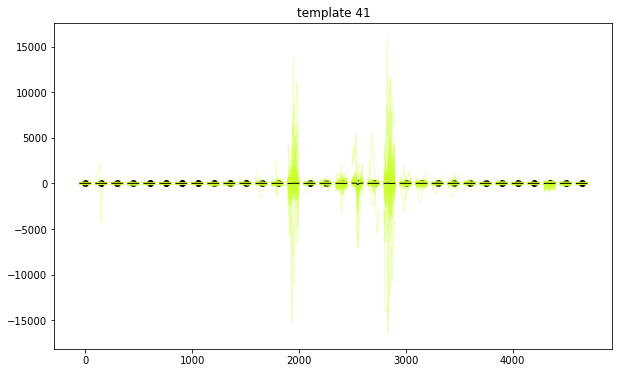

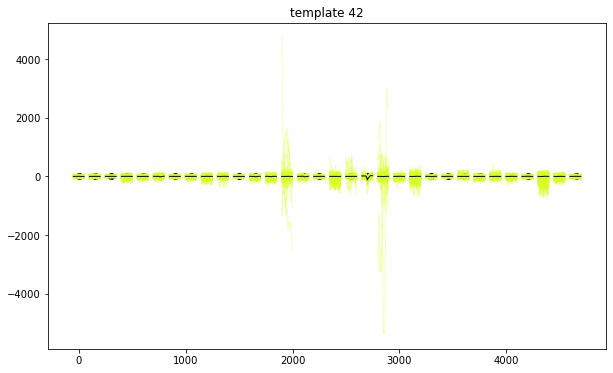

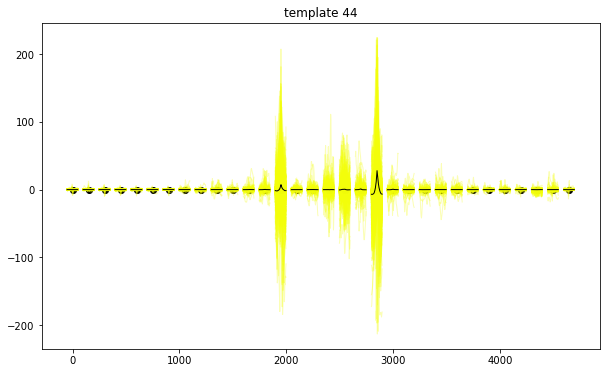

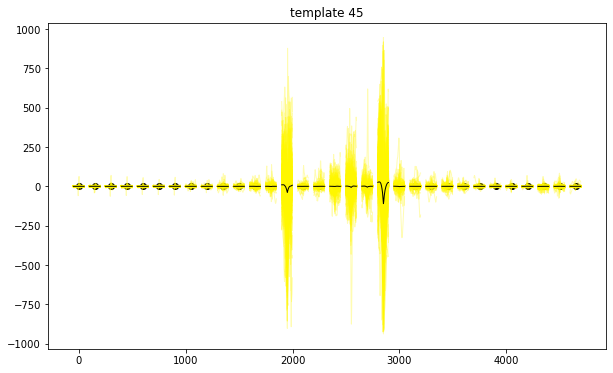

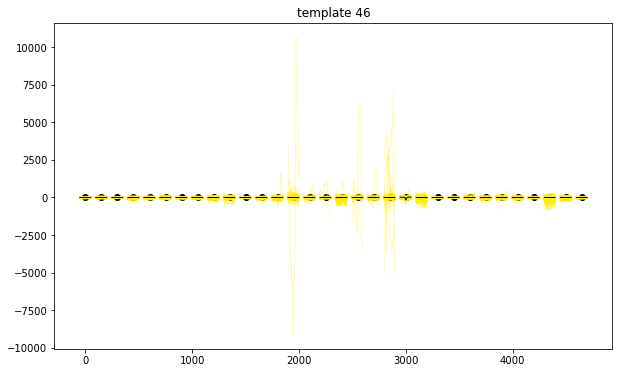

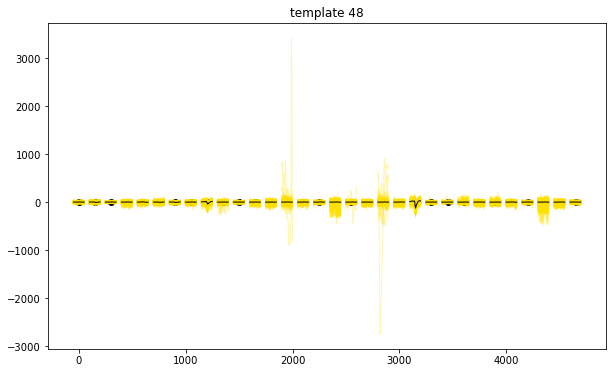

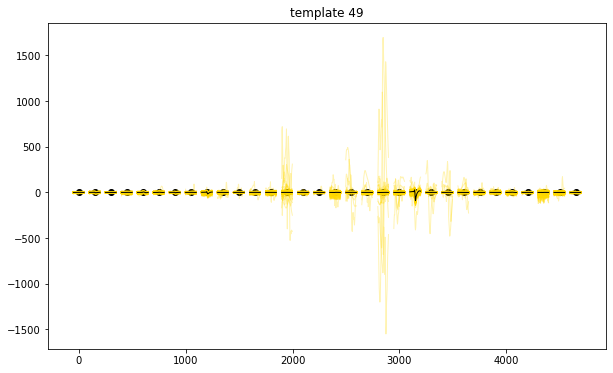

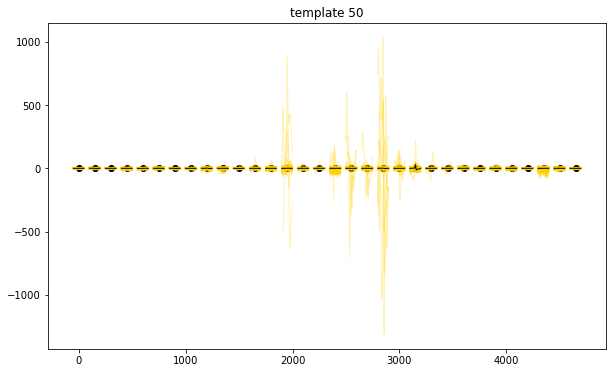

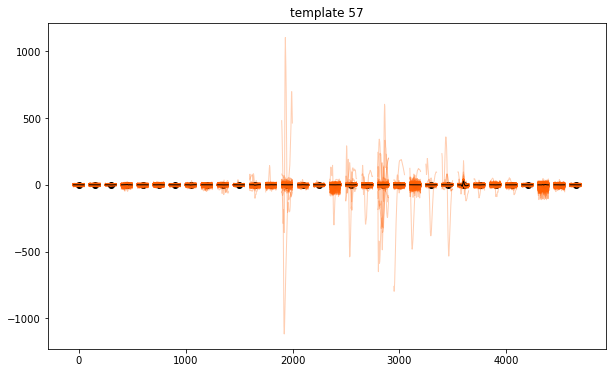

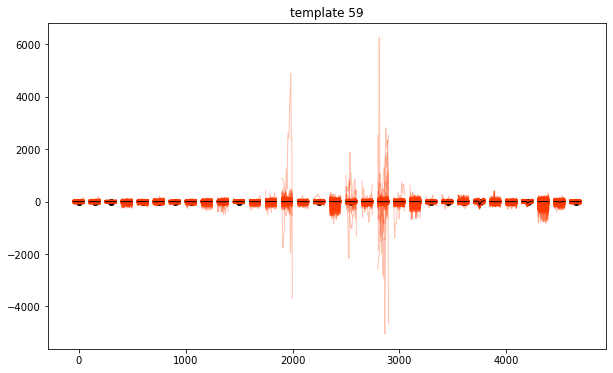

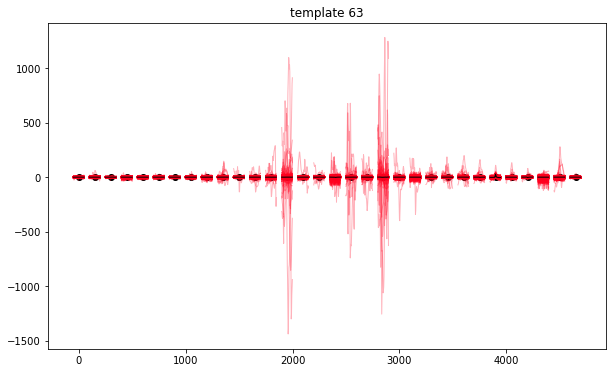

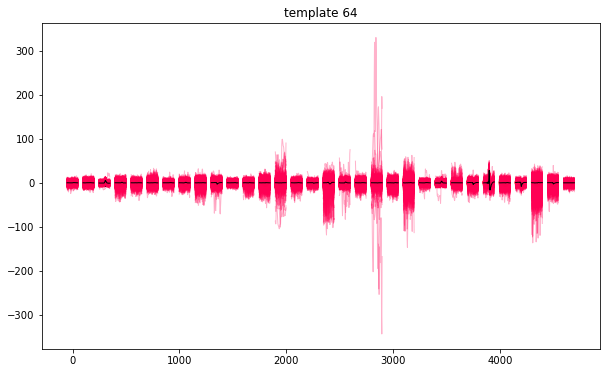

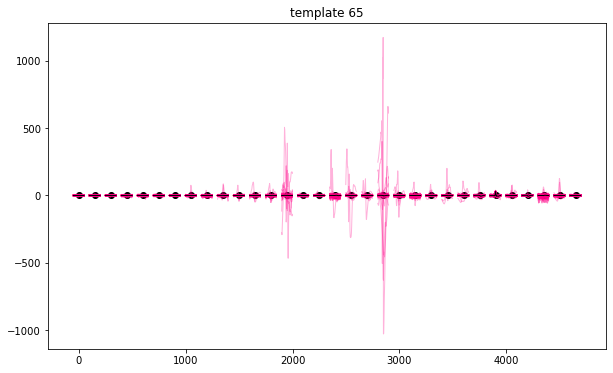

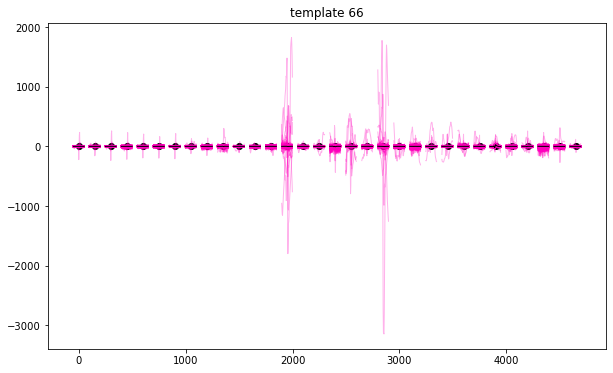

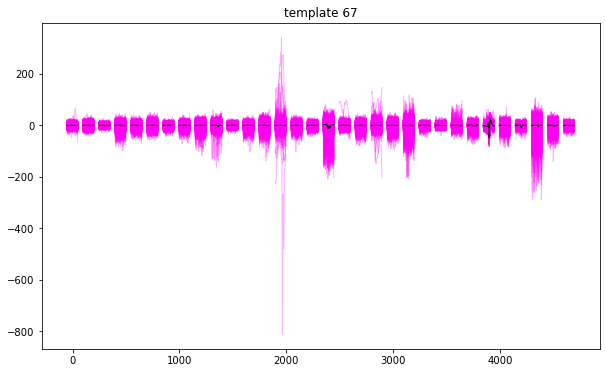

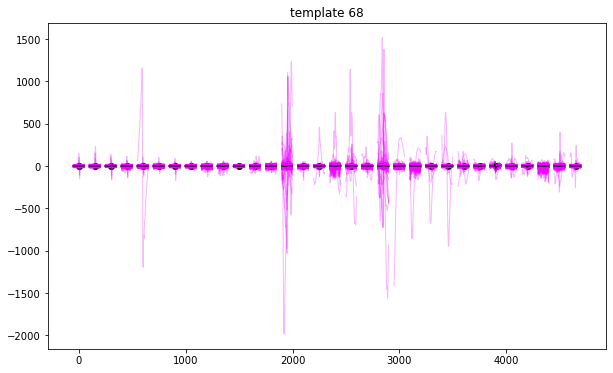

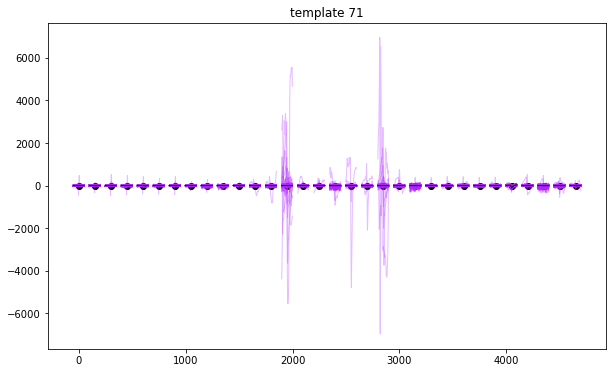

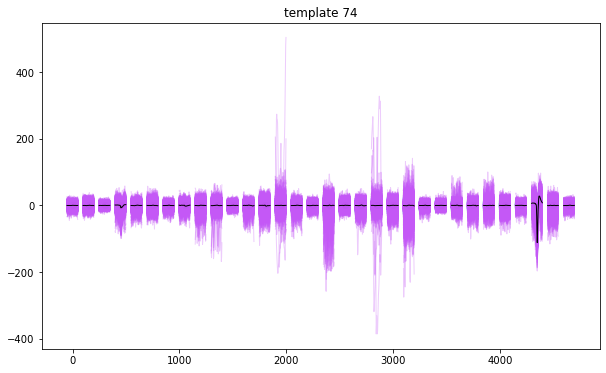

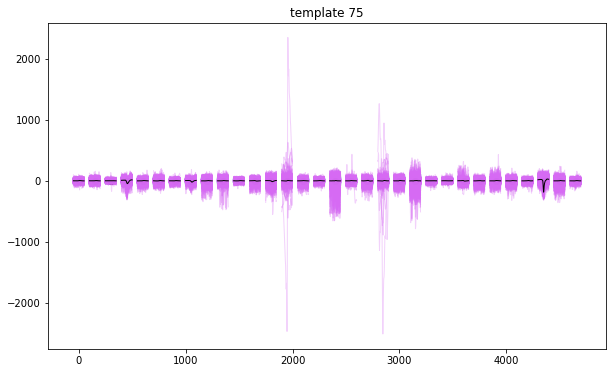

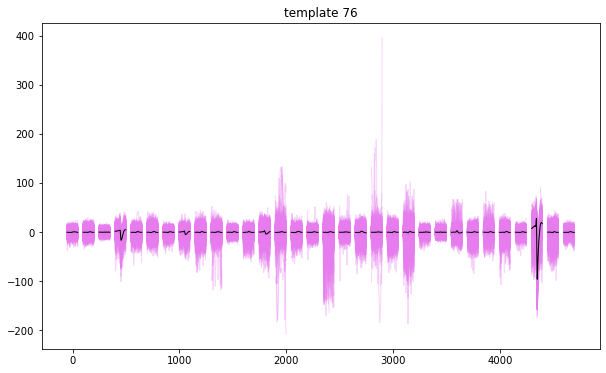

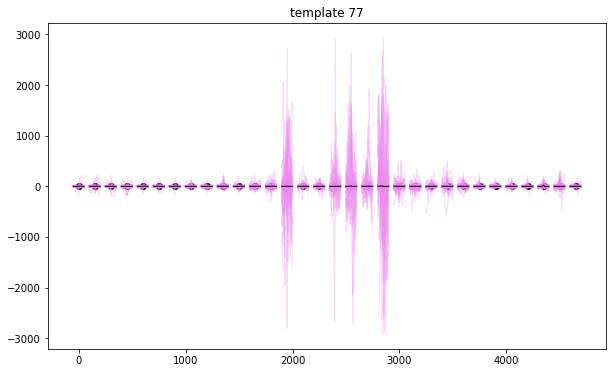

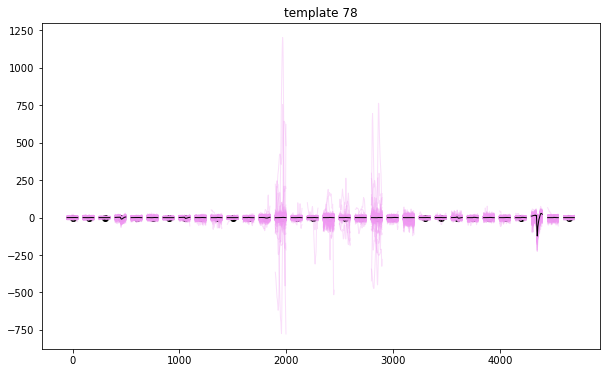

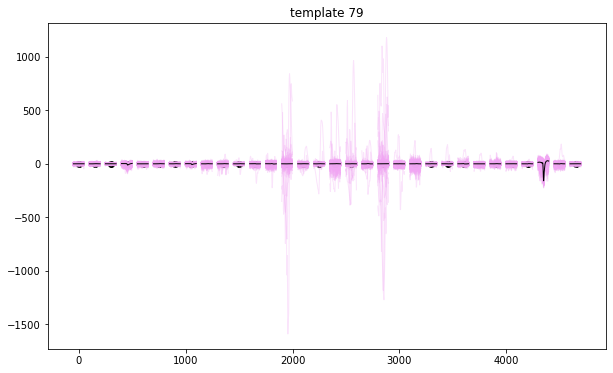

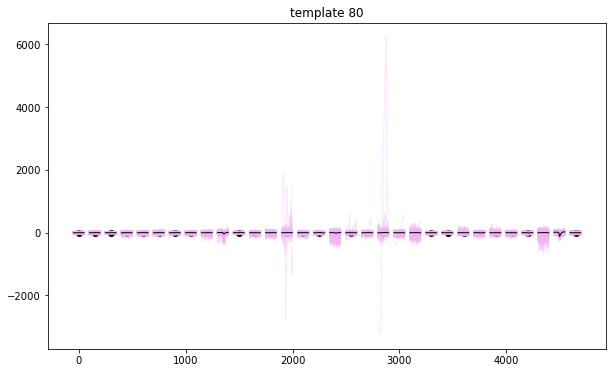

In [31]:
for unit_id in high_snr_units:
    w = sw.plot_unit_waveforms(we_mountainsort, unit_ids=[unit_id], plot_templates=True, plot_channels=True)

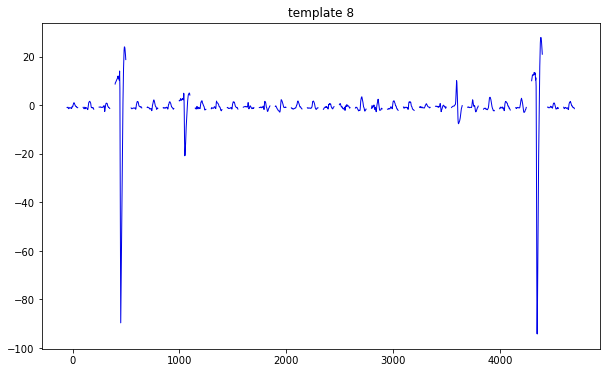

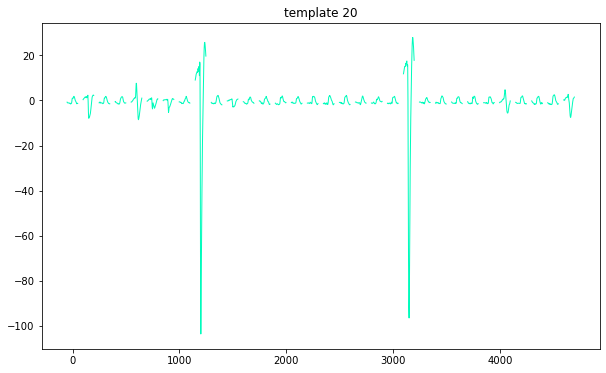

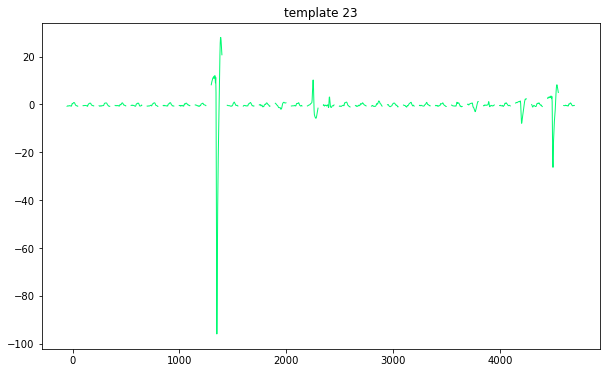

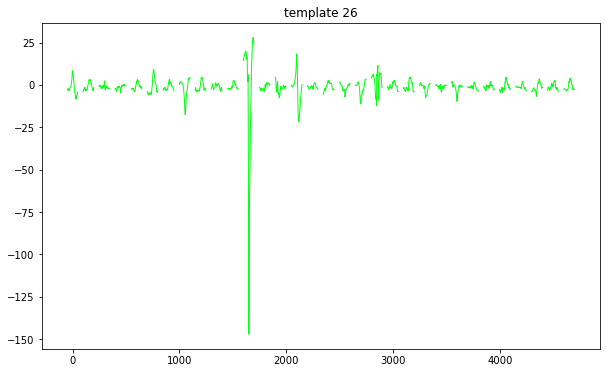

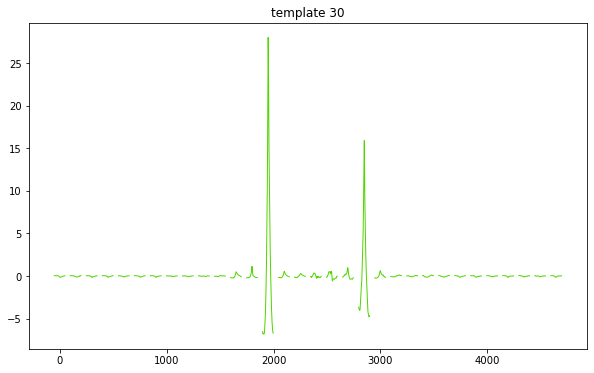

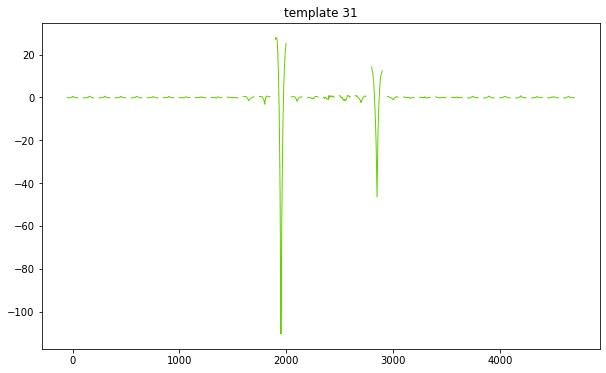

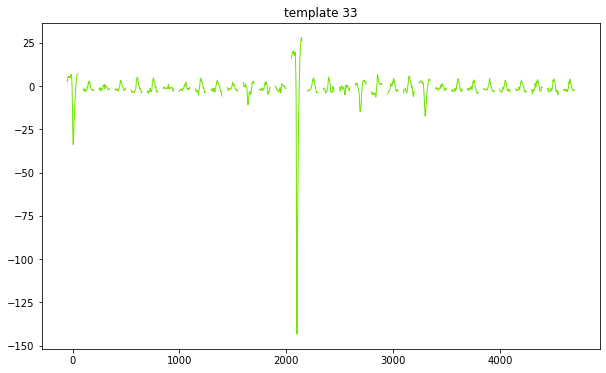

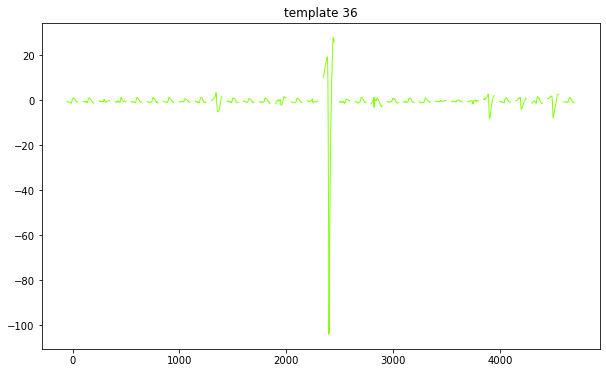

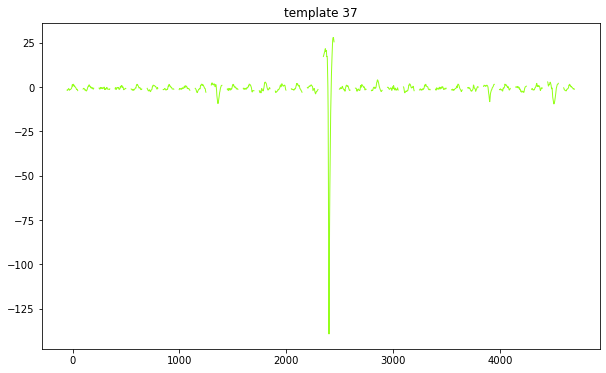

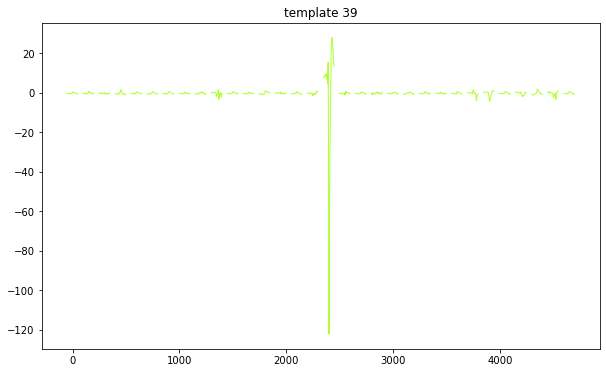

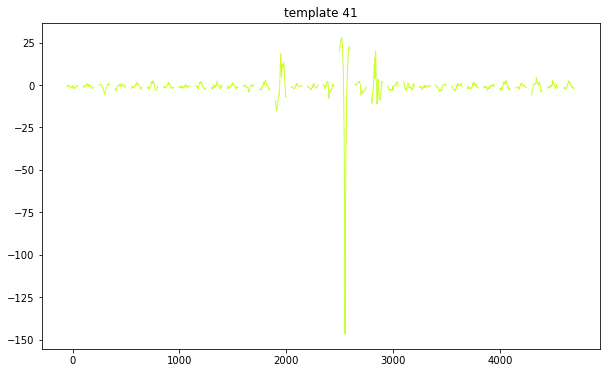

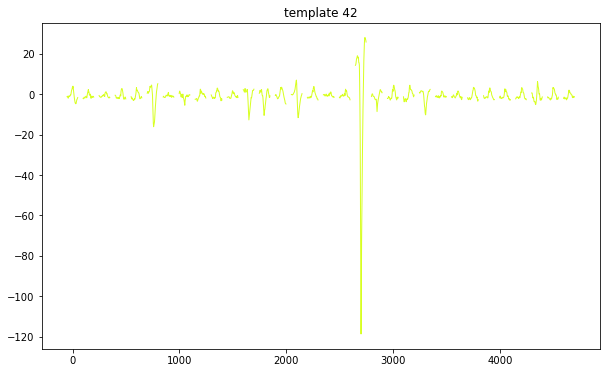

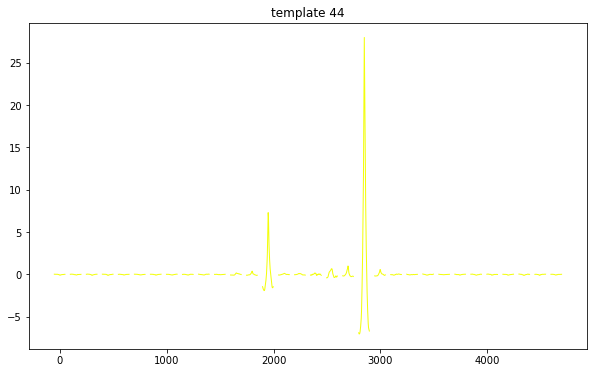

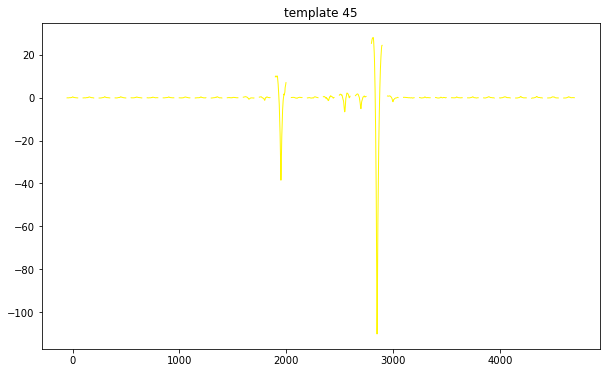

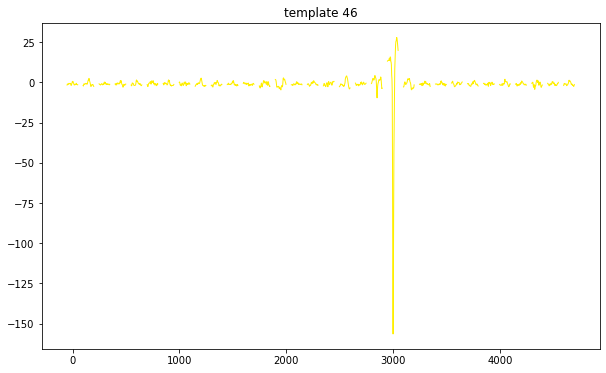

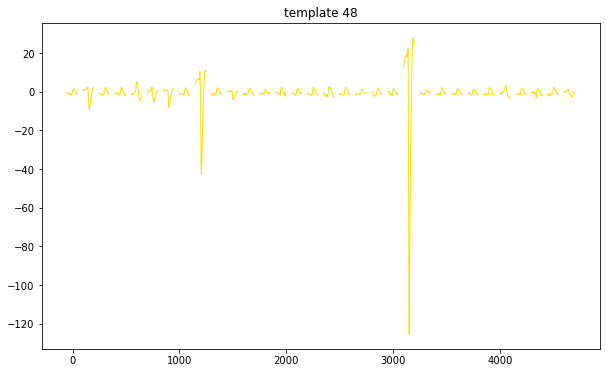

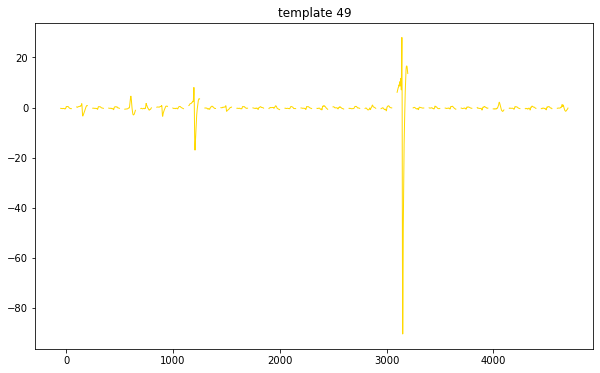

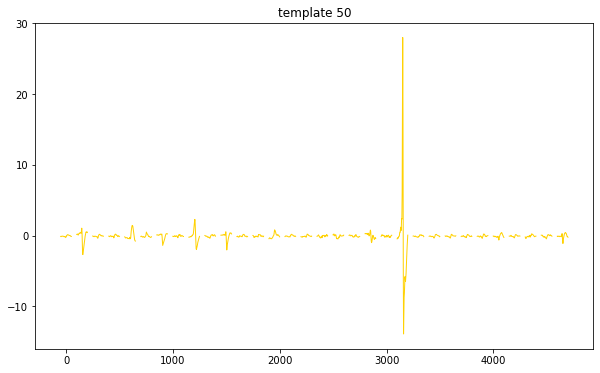

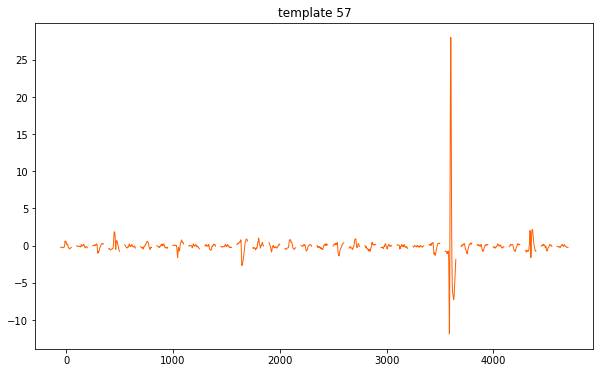

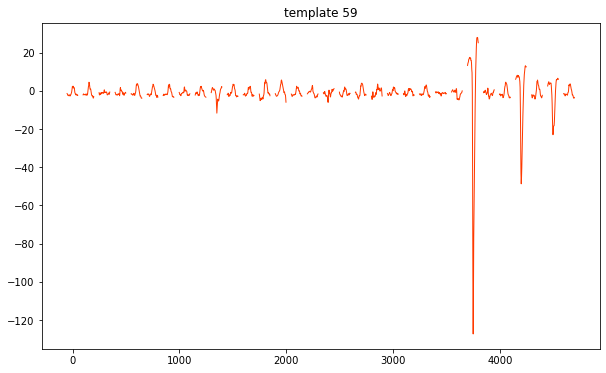

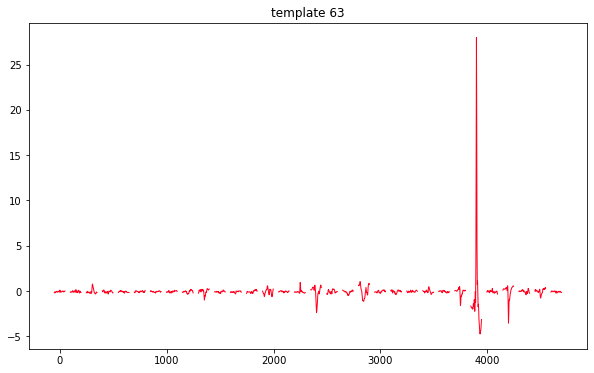

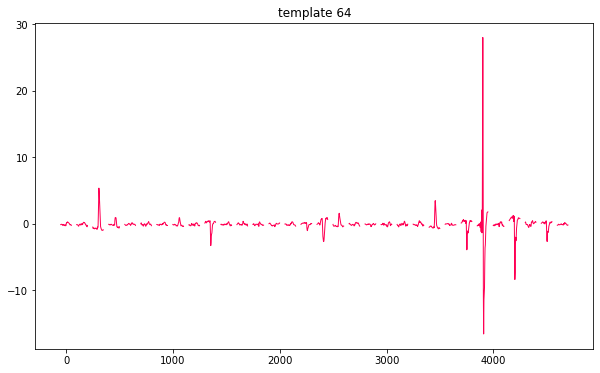

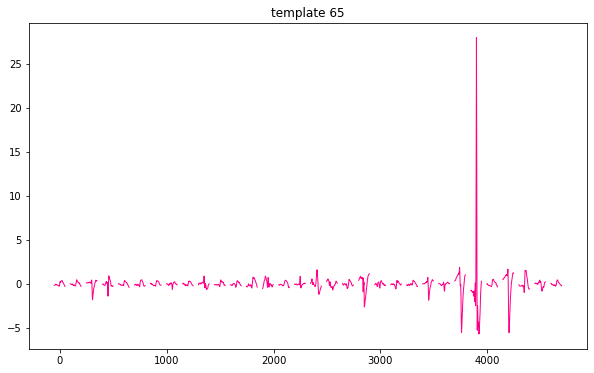

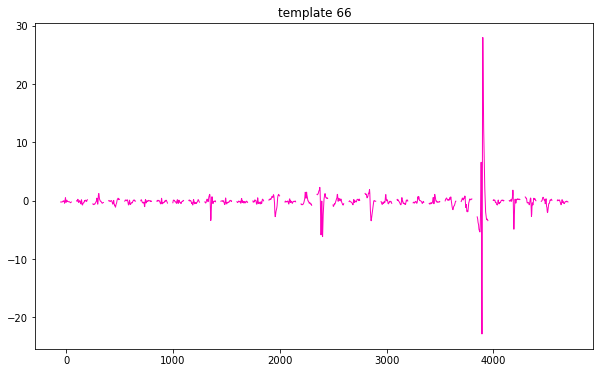

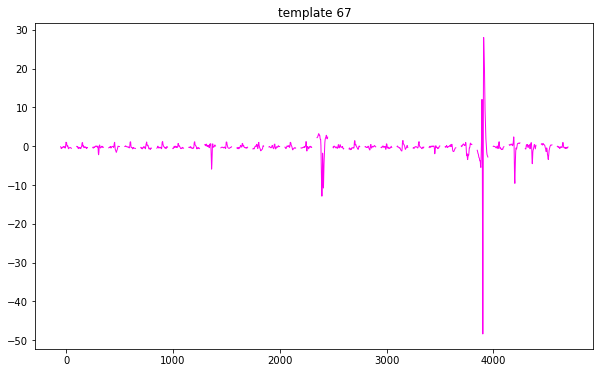

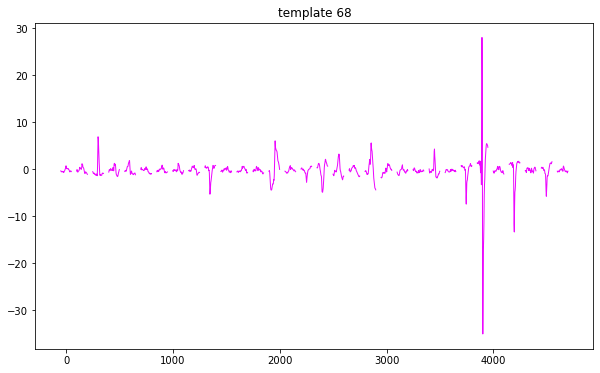

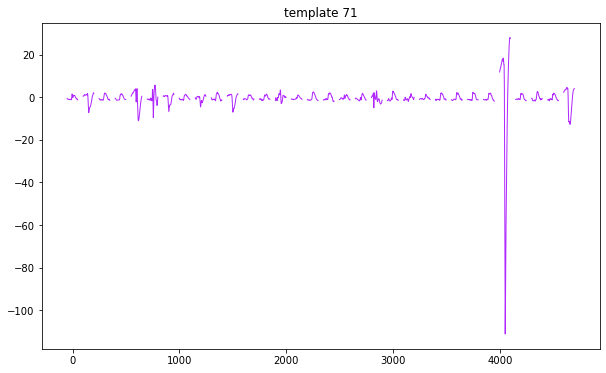

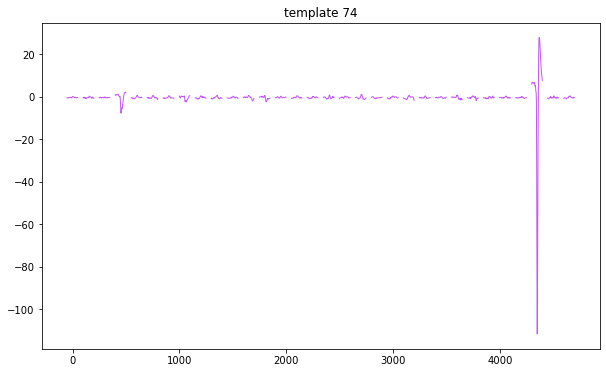

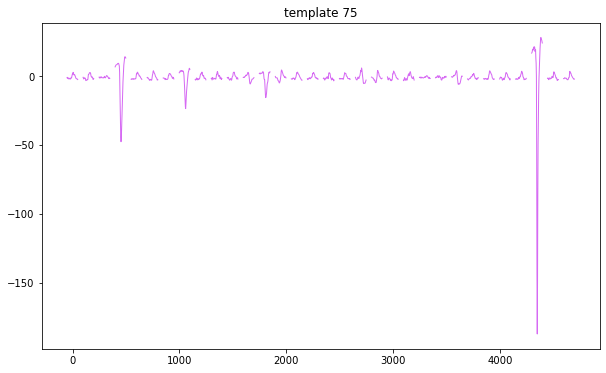

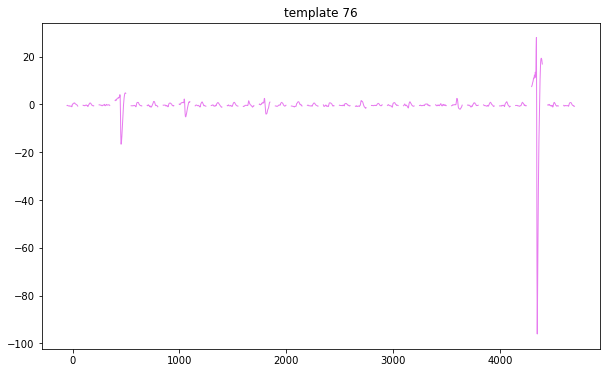

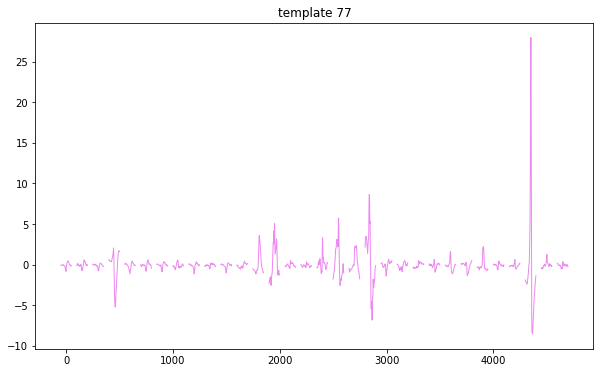

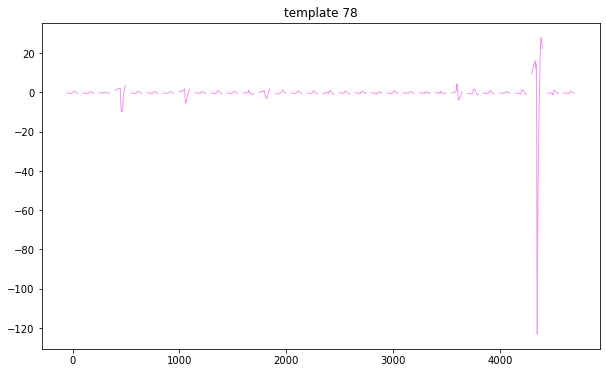

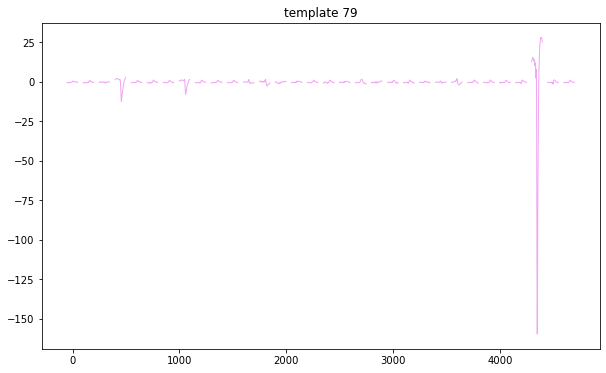

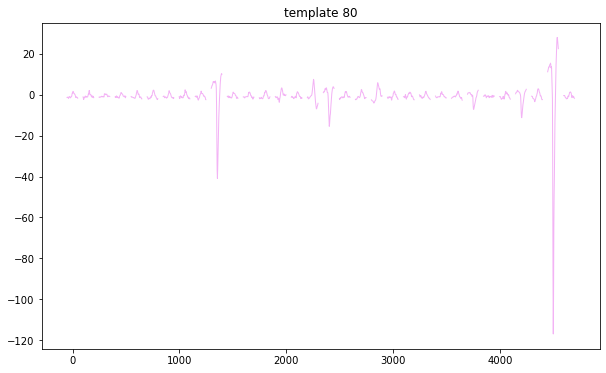

In [32]:
for unit_id in high_snr_units:
    w = sw.plot_unit_templates(we_mountainsort, unit_ids=[unit_id])



/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/spikeinterface/core/baserecording.py:330: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn('There is no Probe attached to this recording. Creating a dummy one with contact positions')


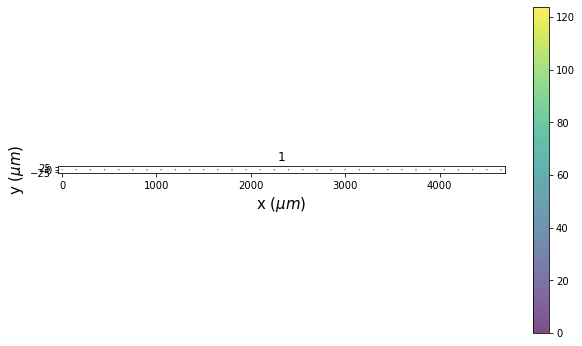

In [38]:
w = sw.plot_unit_probe_map(we_mountainsort, unit_ids=[1])


## Plotting the Waveforms for a single channel

- Plotting the waveforms of units with higher SNR on the specified channel ID 

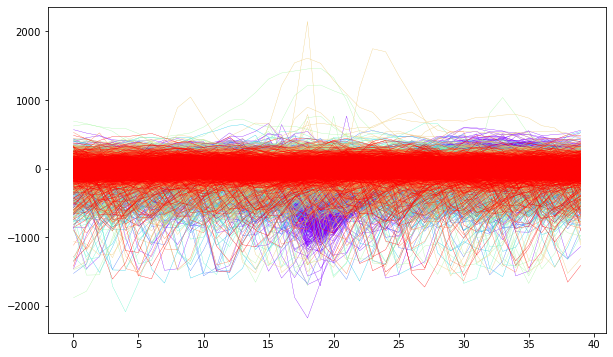

In [39]:
channel_id = 29
number_of_units_to_plot = 8
colors = iter(cm.rainbow(np.linspace(0, 1, number_of_units_to_plot)))

fig, ax = plt.subplots()
for i, unit_id in enumerate(high_snr_units[:number_of_units_to_plot]):
    wf = we_mountainsort.get_waveforms(unit_id)
    color = next(colors)
    ax.plot(wf[:, :, channel_id].T, color=color, lw=0.3)

- Plotting the Average Waveforms (AKA Unit templates)

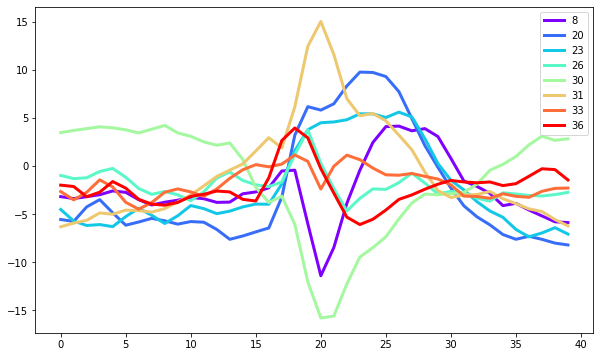

In [34]:
channel_id = 2
number_of_units_to_plot = 8
colors = iter(cm.rainbow(np.linspace(0, 1, number_of_units_to_plot)))

fig, ax = plt.subplots()
for i, unit_id in enumerate(high_snr_units[:number_of_units_to_plot]):
    template = we_mountainsort.get_template(unit_id)
    color = next(colors)
    ax.plot(template[:, channel_id].T, color=color, lw=3, label=unit_id)
ax.legend()

- Plotting the Unit Summary

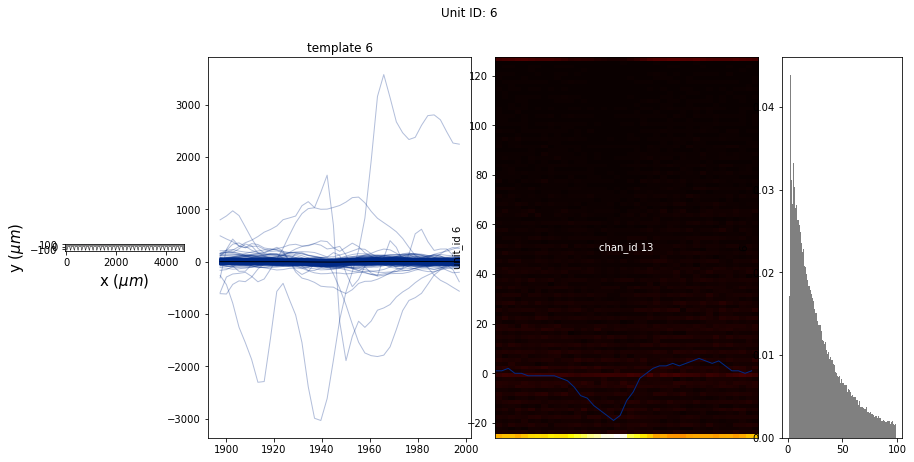

In [104]:
w = sw.plot_unit_summary(we_mountainsort, unit_id=6)

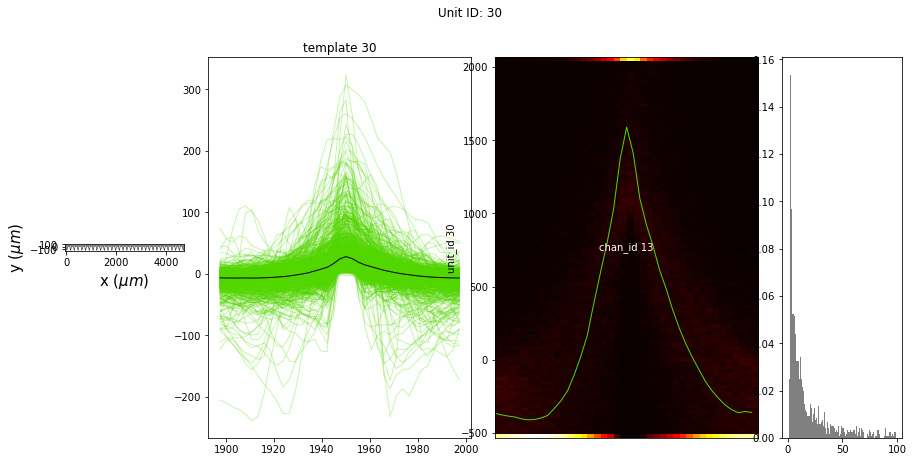

In [141]:
w = sw.plot_unit_summary(we_mountainsort, unit_id=30)


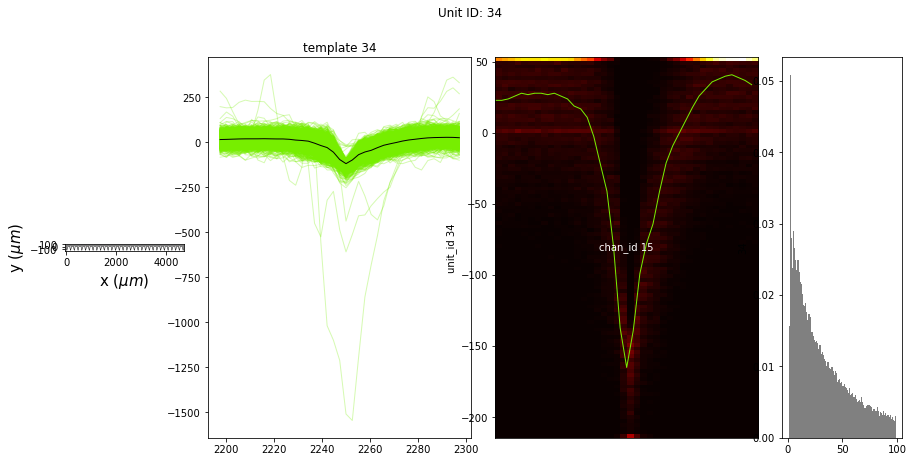

In [126]:
w = sw.plot_unit_summary(we_mountainsort, unit_id=34)

- Waveform and Template Shapes
    - For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). 

In [46]:
unit_id = 5

waveforms = we_mountainsort.get_waveforms(unit_id=unit_id)
print(f"Waveforms shape: {waveforms.shape}")
template = we_mountainsort.get_template(unit_id=unit_id)
print(f"Template shape: {template.shape}")
all_templates = we_mountainsort.get_all_templates()
print(f"All templates shape: {all_templates.shape}")



Waveforms shape: (2000, 40, 32)
Template shape: (40, 32)
All templates shape: (83, 40, 32)


- The number of spikes for other waveforms
    - All are num waveforms are maxed out because we specied with the Waveform Extractor

In [47]:
for unit in spike_sorted_object.get_unit_ids():
    waveforms = we_mountainsort.get_waveforms(unit_id=unit)
    spiketrain = spike_sorted_object.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")


Unit 1 - num waveforms: 2000 - num spikes: 63128
Unit 2 - num waveforms: 2000 - num spikes: 117394
Unit 3 - num waveforms: 2000 - num spikes: 84923
Unit 4 - num waveforms: 2000 - num spikes: 70130
Unit 5 - num waveforms: 2000 - num spikes: 88735
Unit 6 - num waveforms: 2000 - num spikes: 91683
Unit 7 - num waveforms: 2000 - num spikes: 139628
Unit 8 - num waveforms: 2000 - num spikes: 26575
Unit 9 - num waveforms: 2000 - num spikes: 30923
Unit 10 - num waveforms: 2000 - num spikes: 33509
Unit 11 - num waveforms: 2000 - num spikes: 186383
Unit 12 - num waveforms: 2000 - num spikes: 123124
Unit 13 - num waveforms: 2000 - num spikes: 58128
Unit 14 - num waveforms: 2000 - num spikes: 149095
Unit 15 - num waveforms: 2000 - num spikes: 35462
Unit 16 - num waveforms: 2000 - num spikes: 125326
Unit 17 - num waveforms: 2000 - num spikes: 49681
Unit 18 - num waveforms: 2000 - num spikes: 179197
Unit 19 - num waveforms: 2000 - num spikes: 51989
Unit 20 - num waveforms: 2000 - num spikes: 11940
Un

# PCA Scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

### Getting the Principal Components

In [48]:
st.compute_principal_components?

- Calculating Principal Components
    - We will first be using the local channel option

In [85]:
pc = st.compute_principal_components(we_mountainsort, load_if_exists=True,
                                     n_components=3, mode='by_channel_local')


In [50]:
len(spike_sorted_object.get_unit_ids())

83

In [51]:
spike_sorted_object.get_unit_ids()[0]

1

- For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). The get_all_components() function returns an array with the label/unit id for each component (all_labels) and an array of dimension (num_all_samples, num_components, num_channels).

In [68]:
pc1 = pc.get_components(unit_id=1)
print(f"PC scores shape: {pc1.shape}")
all_labels, all_pcs = pc.get_all_components()
print(f"All PC scores shape: {all_pcs.shape}")



PC scores shape: (2000, 3, 32)
All PC scores shape: (161740, 3, 32)


- Plotting the PCA for units with high SNR for each channel

(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(1737, 3, 32)
(1690, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(1454, 3, 32)
(1228, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(746, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(885, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(1737, 3, 32)
(1690, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(1454, 3, 32)
(1228, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(746, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(885, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 

/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(1737, 3, 32)
(1690, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(1454, 3, 32)
(1228, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(746, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(885, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(1737, 3, 32)
(1690, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(1454, 3, 32)
(1228, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(746, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(885, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 

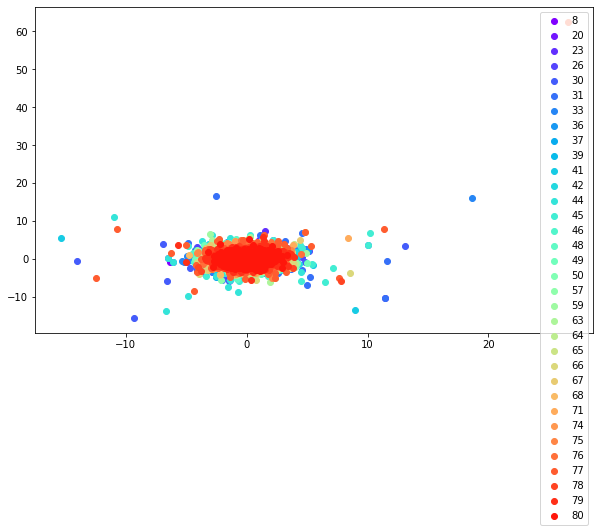

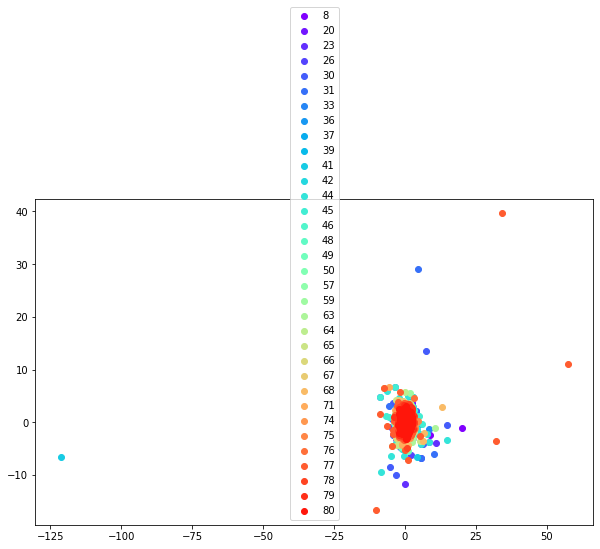

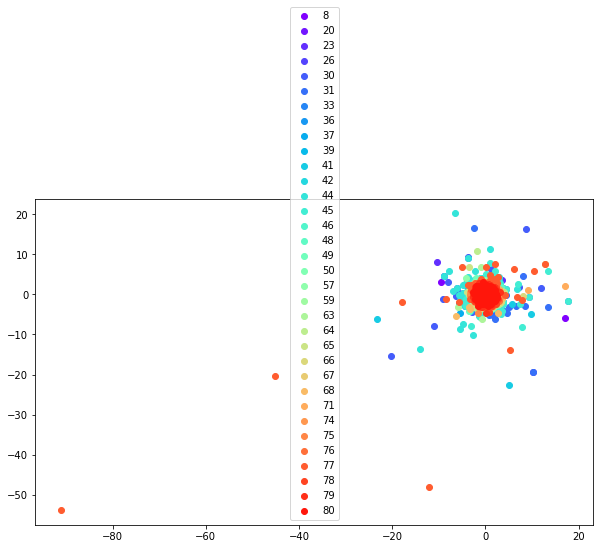

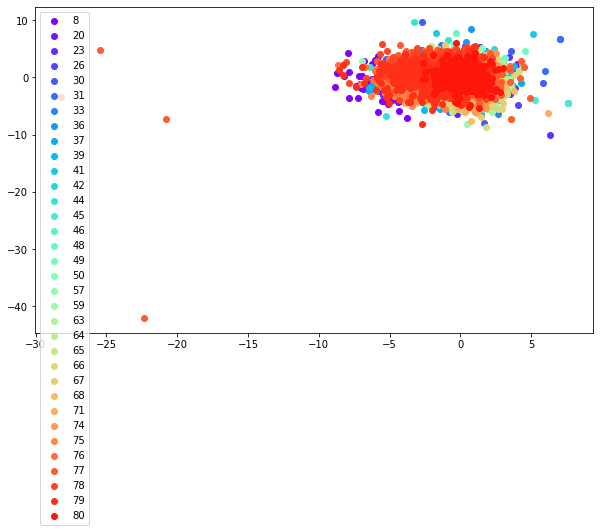

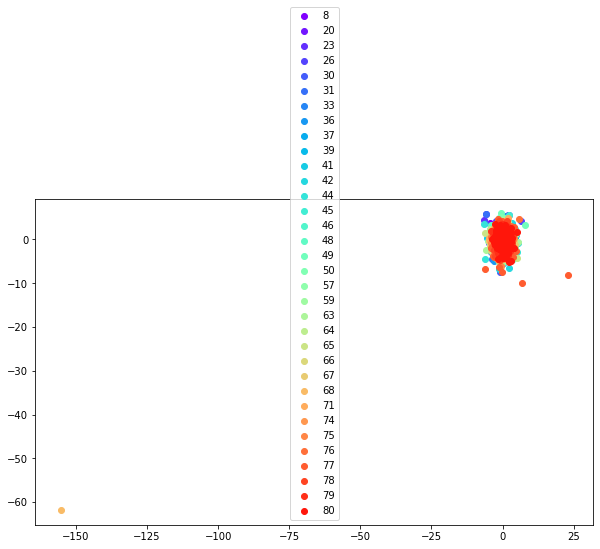

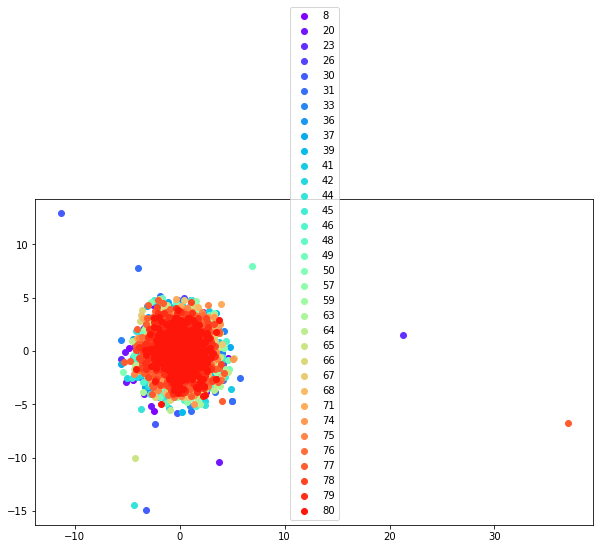

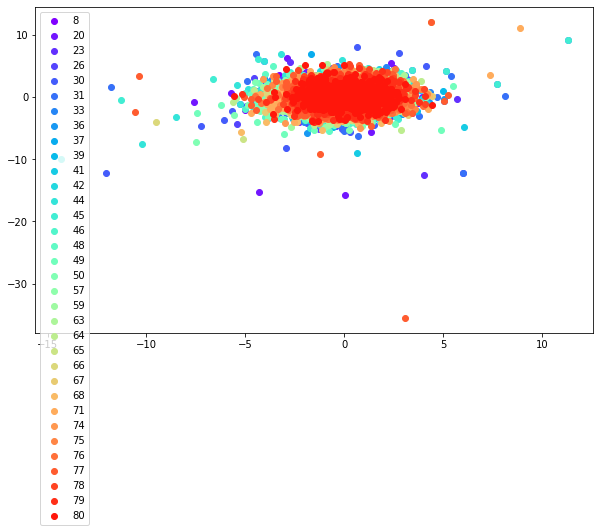

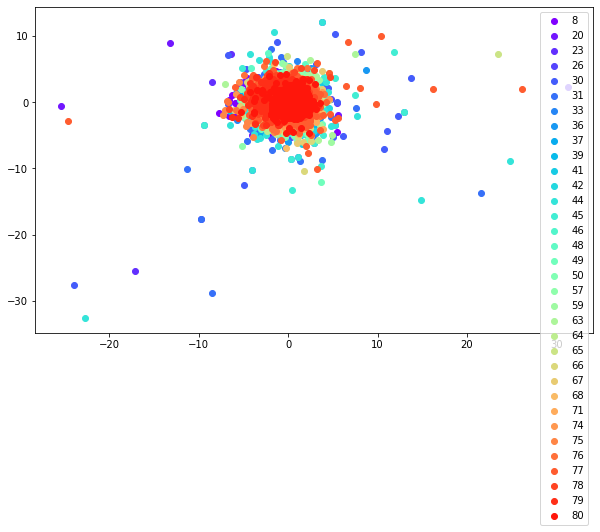

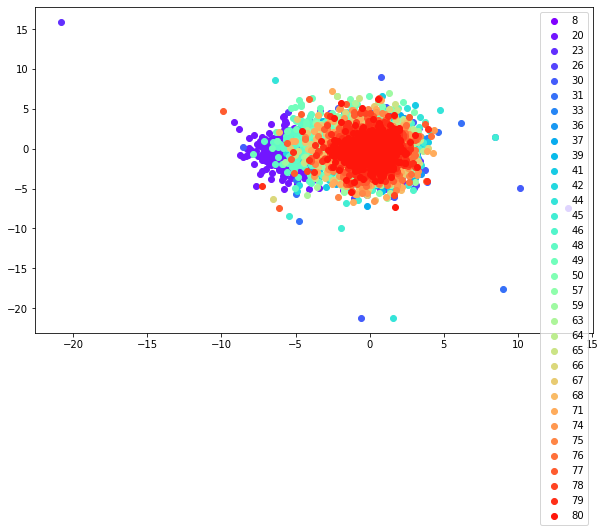

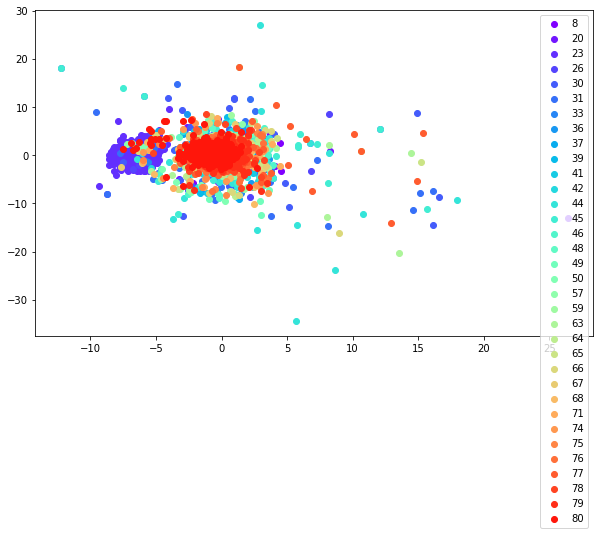

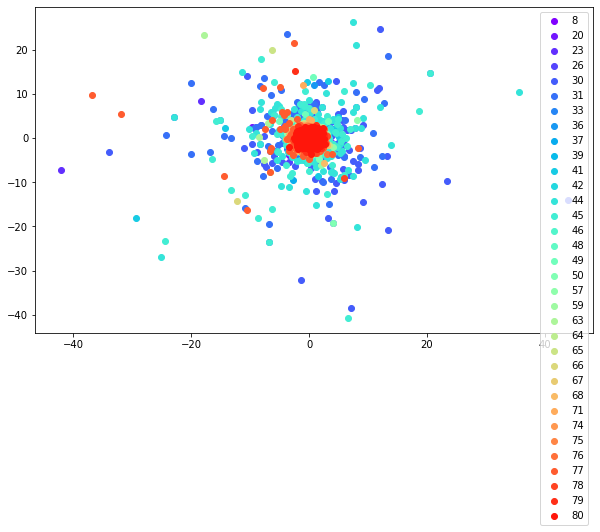

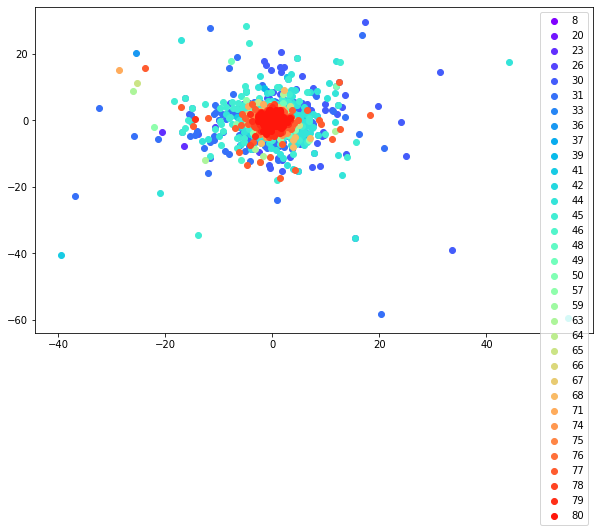

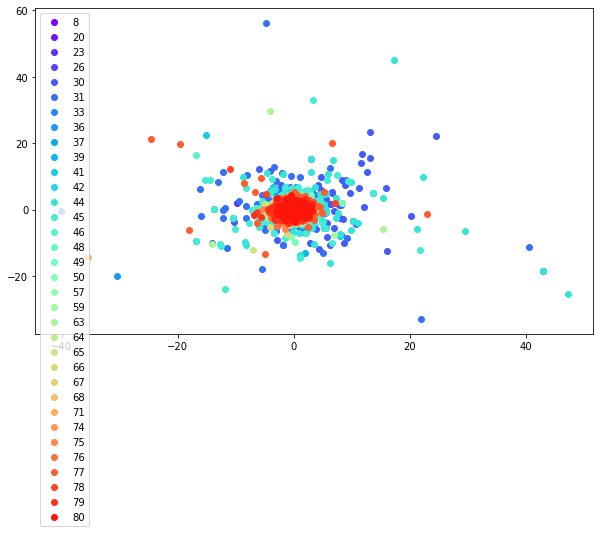

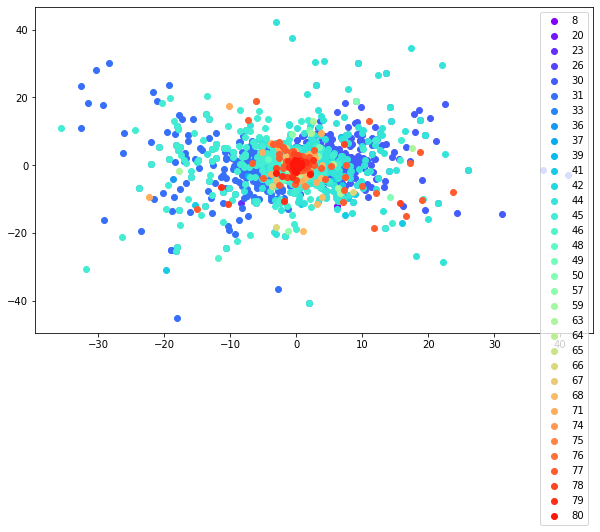

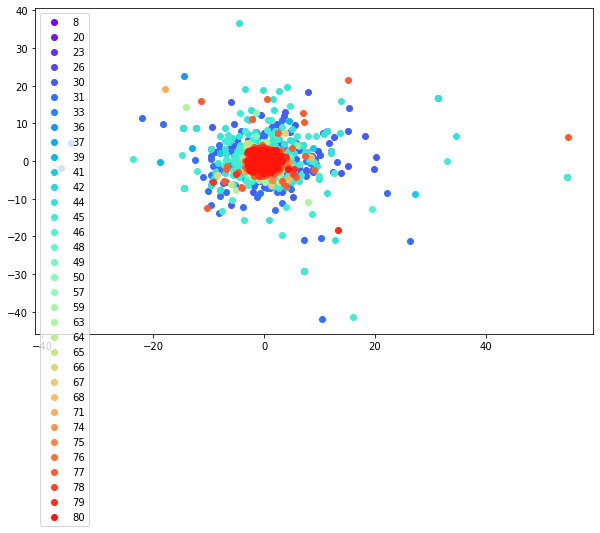

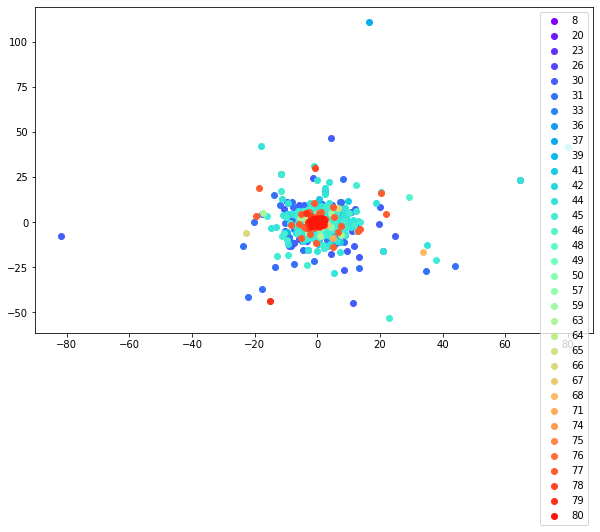

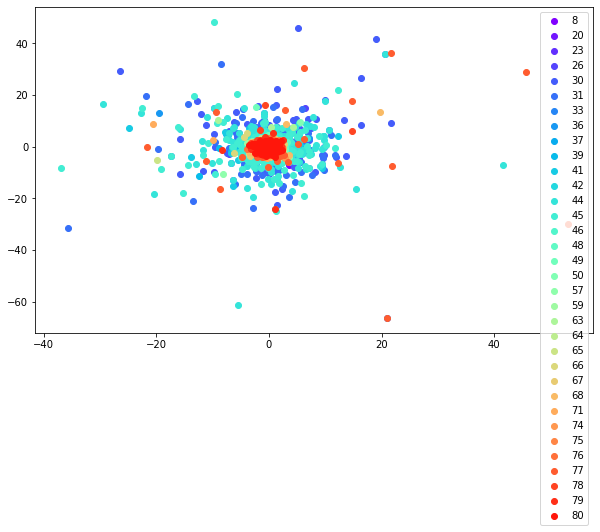

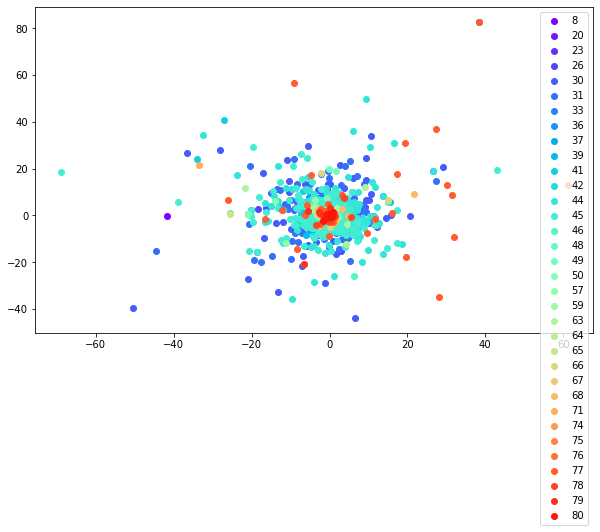

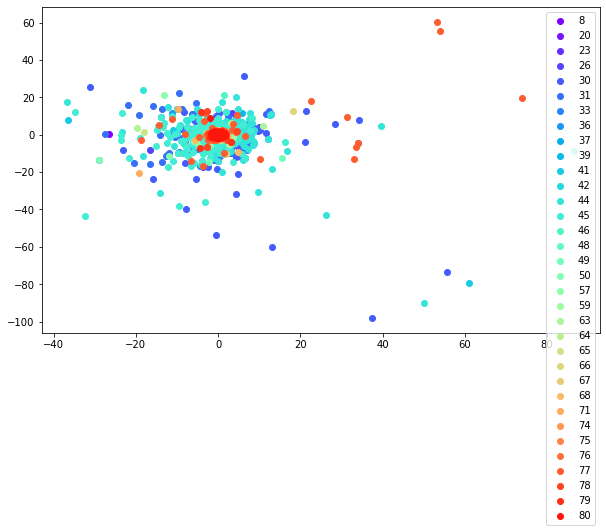

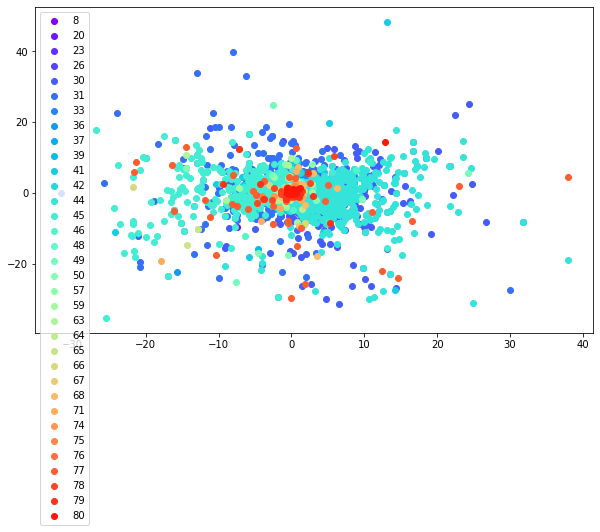

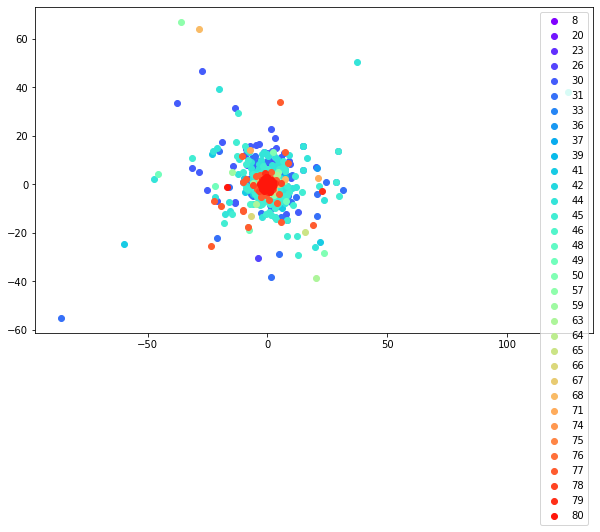

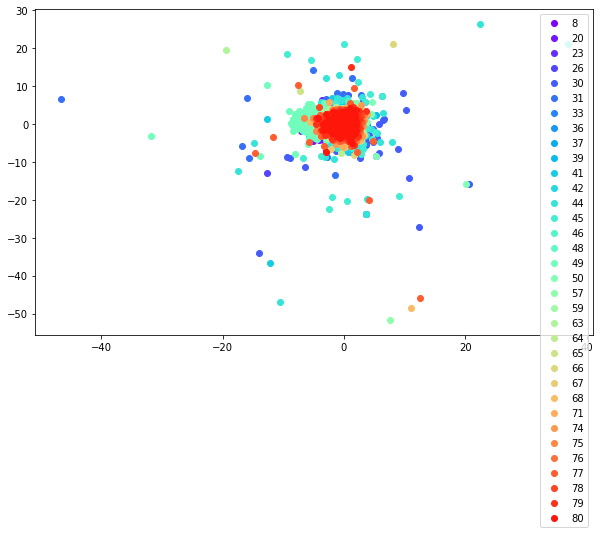

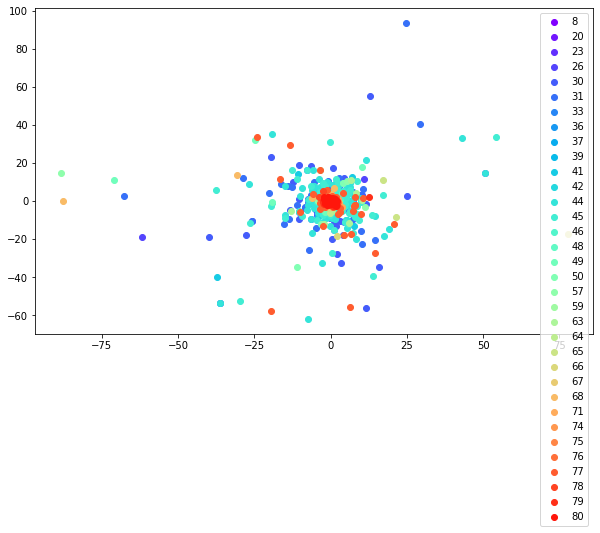

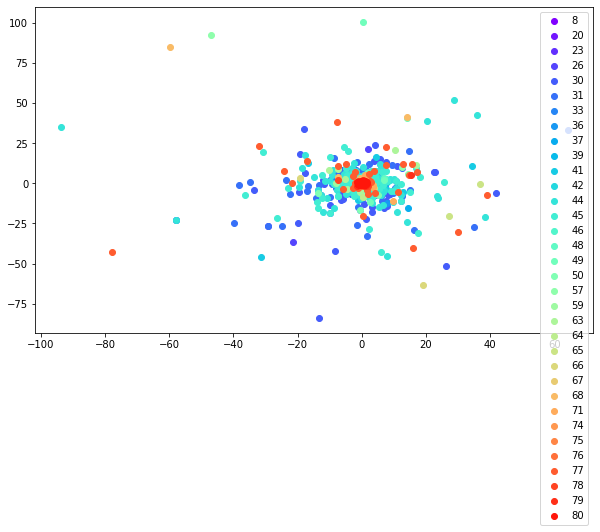

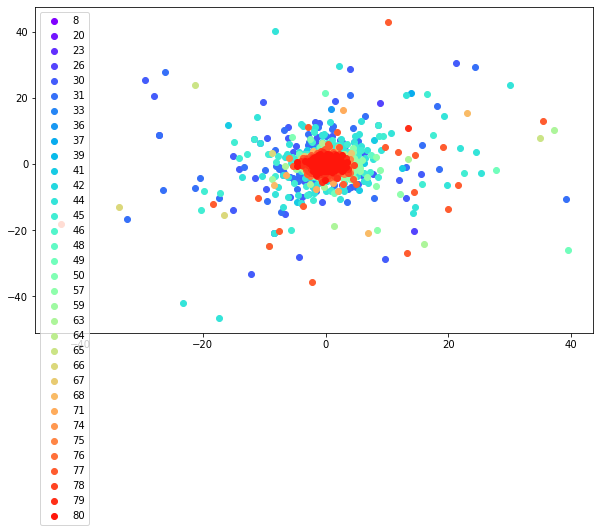

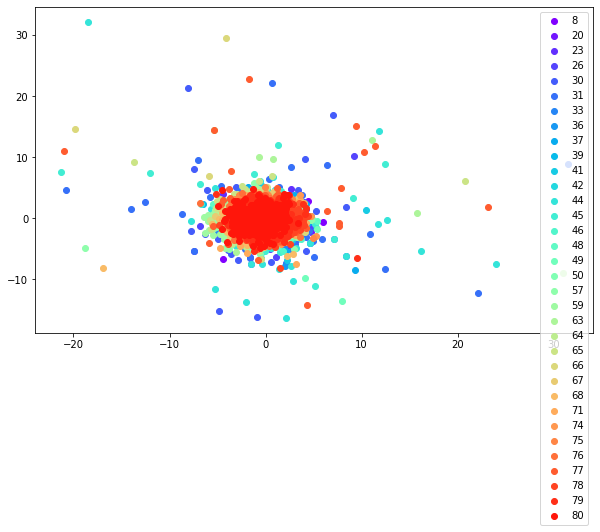

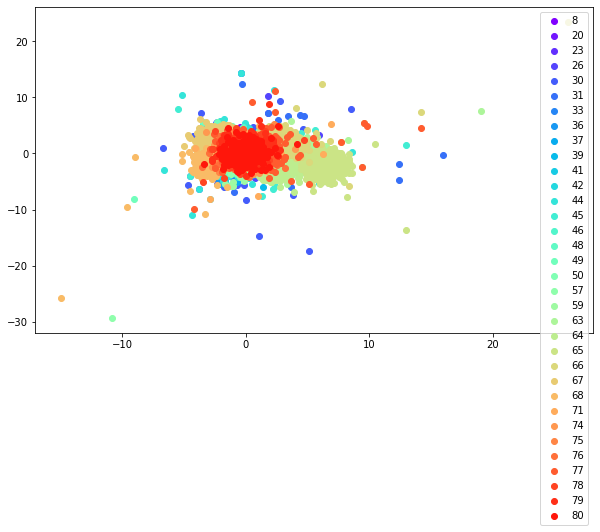

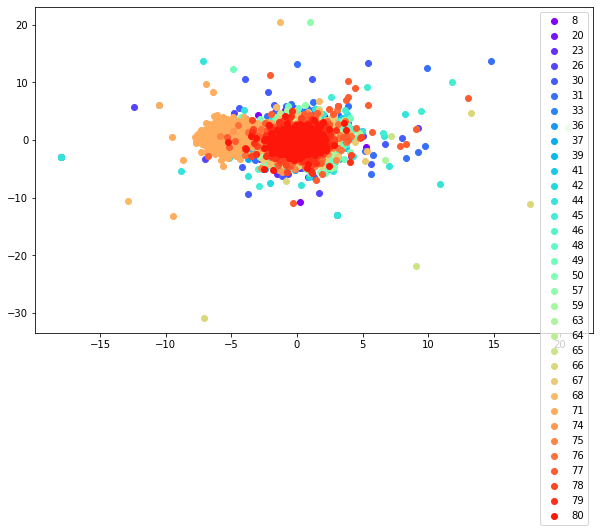

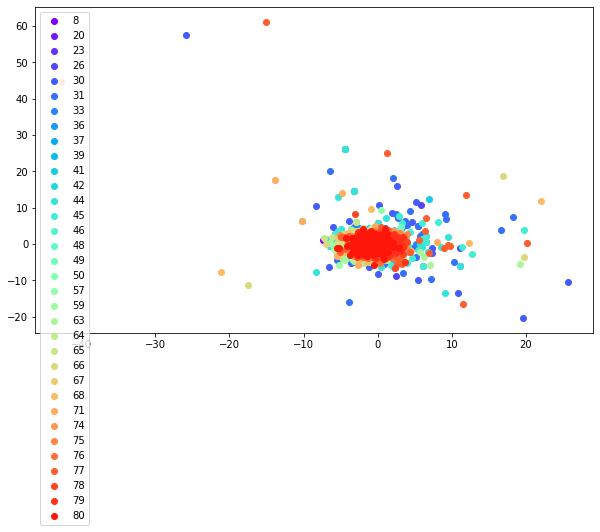

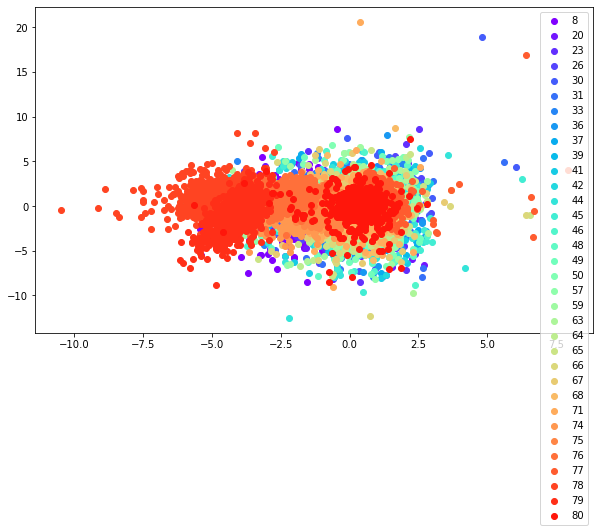

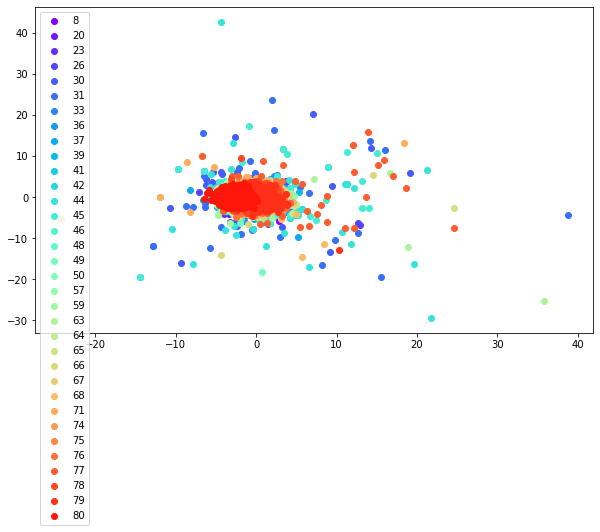

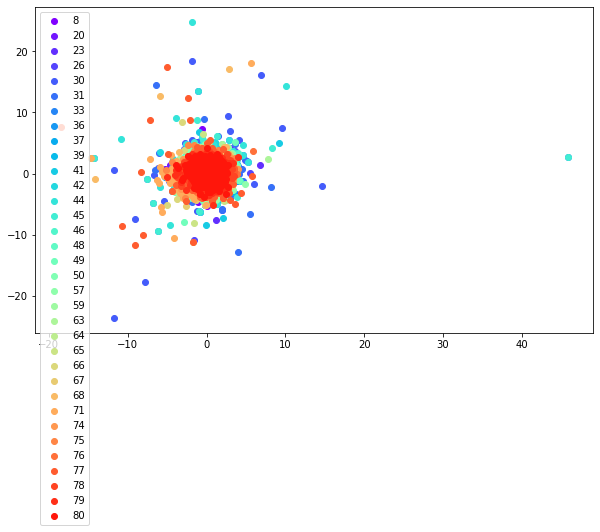

In [69]:
for channel_id in raw_recording.get_channel_ids():
    fig, ax = plt.subplots()
    n = len(high_snr_units) + 1
    colors = iter(cm.rainbow(np.linspace(0, 1, n)))
    for i, unit_id in enumerate(high_snr_units):
        comp = pc.get_components(unit_id)
        print(comp.shape)
        color = next(colors)
        ax.scatter(comp[:, 0, int(channel_id)], comp[:, 1, int(channel_id)], color=color, label=unit_id)
    plt.legend()

## Spike Amplitudes

- Spike amplitudes can be computed with the `get_spike_amplitudes` function.


In [55]:
amplitudes = st.get_spike_amplitudes(we_mountainsort, outputs="concatenated", progress_bar=True)

extract amplitudes: 100%|#####| 1/1 [00:05<00:00,  5.47s/it]


In [56]:
amplitudes[0].shape

(4874357,)

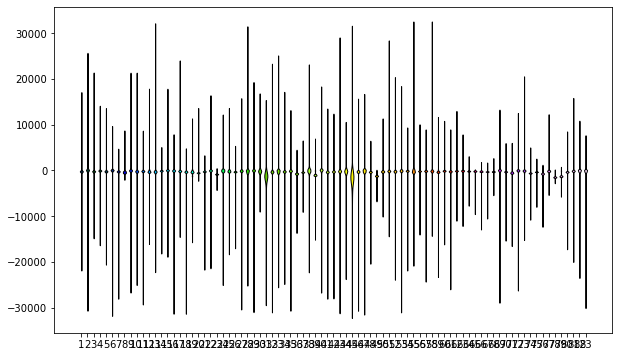

In [57]:
sw.plot_amplitudes_distribution(we_mountainsort, unit_ids=high_snr_units)

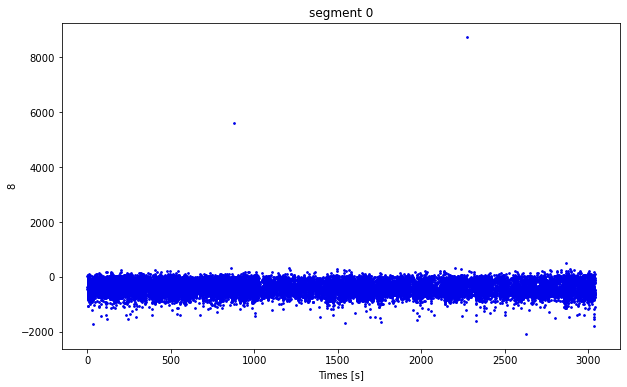

In [58]:
sw.plot_amplitudes_timeseries(we_mountainsort, unit_ids=high_snr_units[:1])

By default, all amplitudes are concatenated in one array.

The correspinding spike times and labels can be easily retrieved as:

In [59]:
all_spike_times, all_spike_labels = spike_sorted_object.get_all_spike_trains()[0]


- The [0] index is to select the first segment. In case of multiple segments each element will correspond to a different segment and will contain spike times and labels for that segment.


# Compute template metrics

- Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `toolkit` allows one to compute several of these metrics:

In [60]:
template_metrics = st.calculate_template_metrics(we_mountainsort)

/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [61]:
template_metrics


peak_to_valley peak_trough_ratio half_width repolarization_slope  \
1          0.0005         -0.803788     0.0004        161015.992165   
2          0.0008         -0.158517     0.0002        319072.496947   
3         0.00065         -0.114561     0.0002        647918.880463   
4         0.00035         -0.684086    0.00045        140296.005011   
5         0.00065         -0.097561     0.0002        372851.133619   
..            ...               ...        ...                  ...   
79        0.00075         -0.175434     0.0002       5177790.876116   
80         0.0007         -0.239448    0.00025          817988.9134   
81        0.00065         -5.539581    0.00205         82759.403728   
82         0.0007         -0.229294    0.00035        105137.977884   
83        0.00065         -0.142528     0.0002        389188.694897   

   recovery_slope  
1   -37767.528125  
2   -11840.999603  
3   -19139.643397  
4   -25905.406386  
5    -1938.214983  
..            ...  
79 -198433.959961  
80  -78932.006836  
81 -304871.539986  
82   -5054.998398  
83   -6093.211855  

[83 rows x 5 columns]

# Validation and Curation with Quality Metrics

Quality metrics for the spike sorting output are very important to asses the spike sorting performance.
The :code:`spikeinterface.toolkit.qualitymetrics` module implements several quality metrics
to assess the goodness of sorted units. Among those, for example,
are signal-to-noise ratio, ISI violation ratio, isolation distance, and many more.
Theses metrics are built on top of WaveformExtractor class and return a dictionary with the unit ids as keys:



In [86]:
quality_metrics=st.compute_quality_metrics(we_mountainsort, waveform_principal_component=pc)

In [118]:
quality_metrics["d_prime"] > 2

1     False
2      True
3     False
4      True
5      True
      ...  
79     True
80     True
81    False
82    False
83    False
Name: d_prime, Length: 83, dtype: bool

In [121]:
dfx=quality_metrics[quality_metrics["d_prime"] > 2]

In [122]:
dfx

num_spikes  firing_rate  presence_ratio        snr  isi_violations_rate  \
2       117394    38.634573            1.00   3.915543                  0.0   
4        70130    23.079907            1.00   0.058127                  0.0   
5        88735    29.202846            1.00   3.655133                  0.0   
6        91683    30.173038            1.00   0.337240                  0.0   
8        26575     8.745880            1.00   6.910326                  0.0   
11      186383    61.338975            1.00   4.771400                  0.0   
12      123124    40.520326            1.00   4.124538                  0.0   
13       58128    19.130028            1.00   4.042008                  0.0   
14      149095    49.067428            1.00   4.552461                  0.0   
16      125326    41.245008            1.00   4.524814                  0.0   
18      179197    58.974050            1.00   4.958259                  0.0   
19       51989    17.109672            1.00   3.564260                  0.0   
20       11940     3.929475            1.00  11.098104                  0.0   
23        5414     1.781757            0.99  15.505461                  0.0   
25       79174    26.056304            1.00   3.566338                  0.0   
26      133619    43.974249            1.00   5.852312                  0.0   
28      127444    41.942046            1.00   4.972665                  0.0   
33      131117    43.150837            1.00   5.756935                  0.0   
34       70454    23.186536            1.00   4.675486                  0.0   
36       20934     6.889416            1.00  11.217066                  0.0   
39       27220     8.958150            1.00  15.491709                  0.0   
48      177907    58.549509            1.00   6.561506                  0.0   
49        4852     1.596802            0.99  18.331381                  0.0   
50        9733     3.203148            1.00   8.900867                  0.0   
51       11301     3.719179            1.00   4.971792                  0.0   
56       93324    30.713094            1.00   4.722252                  0.0   
57       20797     6.844330            1.00  10.311315                  0.0   
59      139020    45.751728            1.00   5.595562                  0.0   
61       29835     9.818751            1.00   3.825127                  0.0   
63        6002     1.975269            1.00   9.713787                  0.0   
64       22715     7.475547            1.00   8.318272                  0.0   
65         746     0.245510            0.84  19.379200                  0.0   
66        3734     1.228866            1.00   6.394497                  0.0   
67       41677    13.715974            1.00   7.562644                  0.0   
68         885     0.291255            0.98   6.927407                  0.0   
70      190467    62.683027            1.00   4.484943                  0.0   
71        5142     1.692241            1.00   9.618389                  0.0   
74       58902    19.384752            1.00  10.320787                  0.0   
76       63669    20.953581            1.00  11.944688                  0.0   
78        9008     2.964549            1.00  24.422543                  0.0   
79        2656     0.874094            1.00  21.400019                  0.0   
80      193622    63.721343            1.00   5.118241                  0.0   

    isi_violations_count  amplitude_cutoff  isolation_distance    l_ratio  \
2                      0          0.000129           54.584450  27.181907   
4                      0          0.000132           62.019164  16.950441   
5                      0          0.002020           57.141014  23.401946   
6                      0          0.000129           58.589492  21.537656   
8                      0          0.000129           84.054219   5.233832   
11                     0          0.000129           58.457484  22.128681   
12                     0          0.000129           55.179588  26.

In [127]:
dfx[dfx["snr"] > 4.5]

num_spikes  firing_rate  presence_ratio        snr  isi_violations_rate  \
8        26575     8.745880            1.00   6.910326                  0.0   
11      186383    61.338975            1.00   4.771400                  0.0   
14      149095    49.067428            1.00   4.552461                  0.0   
16      125326    41.245008            1.00   4.524814                  0.0   
18      179197    58.974050            1.00   4.958259                  0.0   
20       11940     3.929475            1.00  11.098104                  0.0   
23        5414     1.781757            0.99  15.505461                  0.0   
26      133619    43.974249            1.00   5.852312                  0.0   
28      127444    41.942046            1.00   4.972665                  0.0   
33      131117    43.150837            1.00   5.756935                  0.0   
34       70454    23.186536            1.00   4.675486                  0.0   
36       20934     6.889416            1.00  11.217066                  0.0   
39       27220     8.958150            1.00  15.491709                  0.0   
48      177907    58.549509            1.00   6.561506                  0.0   
49        4852     1.596802            0.99  18.331381                  0.0   
50        9733     3.203148            1.00   8.900867                  0.0   
51       11301     3.719179            1.00   4.971792                  0.0   
56       93324    30.713094            1.00   4.722252                  0.0   
57       20797     6.844330            1.00  10.311315                  0.0   
59      139020    45.751728            1.00   5.595562                  0.0   
63        6002     1.975269            1.00   9.713787                  0.0   
64       22715     7.475547            1.00   8.318272                  0.0   
65         746     0.245510            0.84  19.379200                  0.0   
66        3734     1.228866            1.00   6.394497                  0.0   
67       41677    13.715974            1.00   7.562644                  0.0   
68         885     0.291255            0.98   6.927407                  0.0   
71        5142     1.692241            1.00   9.618389                  0.0   
74       58902    19.384752            1.00  10.320787                  0.0   
76       63669    20.953581            1.00  11.944688                  0.0   
78        9008     2.964549            1.00  24.422543                  0.0   
79        2656     0.874094            1.00  21.400019                  0.0   
80      193622    63.721343            1.00   5.118241                  0.0   

    isi_violations_count  amplitude_cutoff  isolation_distance    l_ratio  \
8                      0          0.000129           84.054219   5.233832   
11                     0          0.000129           58.457484  22.128681   
14                     0          0.000129           57.103593  24.255668   
16                     0          0.000278           55.630684  26.793662   
18                     0          0.000223           61.535961  20.053565   
20                     0          0.000129           99.132061   1.539072   
23                     0          0.000130          182.226207   0.068594   
26                     0          0.000365           55.587601  26.651612   
28                     0          0.000780           61.540142  19.679182   
33                     0          0.000459           60.836880  20.343203   
34                     0          0.002743           57.188685  24.553060   
36                     0          0.002289           82.848060   4.659017   
39                     0          0.000130          108.021343   0.710309   
48                     0          0.000587           62.052848  19.593907   
49                     0          0.001774          115.339300   0.465671   
50                     0          0.007612           65.247522  16.677215   
51                     0          0.002692           49.897877  33.512770   
56        

In [92]:
isi_violations_rate, isi_violations_count = st.compute_isi_violations(we_mountainsort, isi_threshold_ms=1)

In [93]:
print("ISI Violation Rate: {}".format(isi_violations_count))


ISI Violation Rate: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0}


(array([ 0.,  0.,  0.,  0.,  0., 83.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

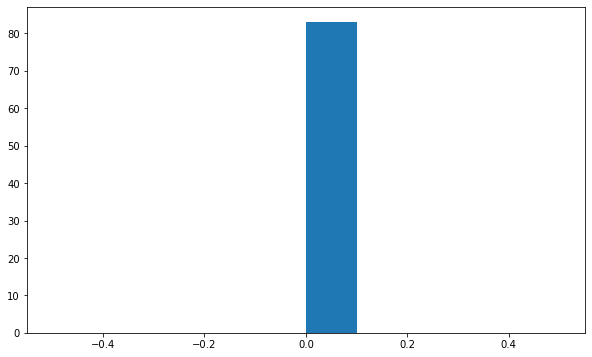

In [64]:
plt.hist(isi_violations_rate.values())

In [65]:
print("ISI Violation Count: {}".format(isi_violations_count))


ISI Violation Count: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0}


(array([ 0.,  0.,  0.,  0.,  0., 83.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

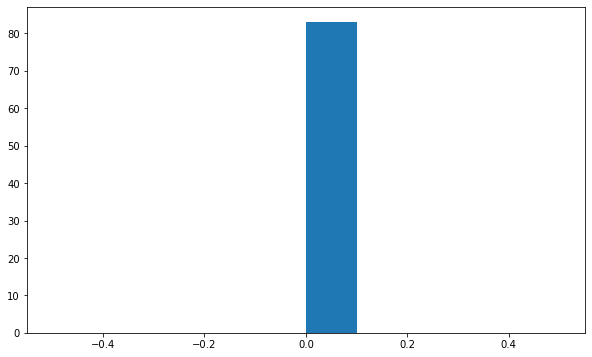

In [66]:
plt.hist(isi_violations_count.values())

All theses quality metrics can be computed in one shot and returned as
a :code:`pandas.Dataframe`



In [ ]:
metrics = st.compute_quality_metrics(we_mountainsort, waveform_principal_component=pc)

- Each row is a Unit

In [ ]:
metrics

Quality metrics can be also used to automatically curate the spike sorting
output. For example, you can select sorted units with a SNR above a
certain threshold:



In [ ]:
snr_thresh = 5
isi_viol_thresh = 0.2

In [ ]:
our_query = f"snr > {snr_thresh} & isi_violations_rate < {isi_viol_thresh}"
print(our_query)

In [ ]:
keep_units = metrics.query(our_query)
keep_unit_ids = keep_units.index.values

In [ ]:
sorting_auto = spike_sorted_object.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(spike_sorted_object.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto.get_unit_ids())}")

## ISI Violations

- https://github.com/SpikeInterface/spikeinterface/blob/master/spikeinterface/toolkit/qualitymetrics/misc_metrics.py
- https://numpy.org/doc/stable/reference/generated/numpy.diff.html

- The code that's used for the ISI Calcuations which suggest that only the differences between neighbors are being calculated

## Filtering based on metrics

- Focusing on:
    - snr, isi_violations_rate, isolation_distance

In [ ]:
good_units = metrics[(metrics["snr"] >= 4) & (metrics["isi_violations_rate"] < 0.01)]

In [ ]:
adequate_units = metrics[(metrics["snr"] >= 4) & (metrics["isi_violations_rate"] < 0.05) & (metrics["isi_violations_rate"] > 0.01)]

In [ ]:
good_units

In [ ]:
adequate_units

- Looking over the unit summaries of units that match our criteria

In [ ]:
for index, unit in good_units.iterrows():
    w = sw.plot_unit_summary(we_mountainsort, unit_id=index)

# Plotting Channels with Multiple Units

## Compute unit maximum channel¶

- For each unit, calculating the channel with the highest the most extreme signal

In [ ]:
extremum_channels_ids = st.get_template_extremum_channel(we_mountainsort, peak_sign='neg')
print(extremum_channels_ids)

In [ ]:
extremum_channels_ids = st.get_template_extremum_channel(we_mountainsort, peak_sign='pos')
print(extremum_channels_ids)

- Getting the channel that's the top channel for multiple units

In [ ]:
channel_to_units = defaultdict(dict)
for k, v in extremum_channels_ids.items():
    channel_to_units[v] = channel_to_units.get(v, []) + [k]

In [ ]:
channel_to_units

In [ ]:
channel_to_multiple_units = {k:v for k, v in channel_to_units.items() if len(v) >=2}

In [ ]:
channel_to_multiple_units

- PCA Plots

In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():

    n = len(multiple_units) + 1
    colors = iter(cm.rainbow(np.linspace(0, 1, n)))

    fig, ax = plt.subplots()
    for i, unit_id in enumerate(multiple_units):
        comp = pc.get_components(unit_id)
        print(comp.shape)
        color = next(colors)
        ax.scatter(comp[:, 0, int(channel)], comp[:, 1, int(channel)], color=color, label=unit_id)
    ax.legend()
    print(channel)
    ax.set_title("PCA Plot for Channel: {}".format(str(channel)))

# Looking over the waveforms for the different unit groups

In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():
    print("Channel: {}".format(channel))
    for unit in multiple_units:
        print("Unit: {}".format(unit))
        sw.plot_unit_waveforms(we_mountainsort, channel_ids=recording.channel_ids, unit_ids=[unit], plot_templates=True, plot_channels=True)
        plt.show()
        plt.close()

In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():
    print("Channel: {}".format(channel))
    for unit in multiple_units:
        print("Unit: {}".format(unit))
        sw.plot_unit_templates(we_mountainsort, channel_ids=recording.channel_ids, unit_ids=[unit], plot_templates=True, plot_channels=True)
        plt.show()
        plt.close()

In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():
    print("Channel: {}".format(channel))
    for unit in multiple_units:
        print("Unit: {}".format(unit))
        w = sw.plot_unit_summary(we_mountainsort, unit_id=unit)
        plt.show()
        plt.close()

## 3D Plots for PCA

In [ ]:
from mpl_toolkits import mplot3d

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')

In [ ]:
channel

In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():

    n = len(multiple_units) + 1
    colors = iter(cm.rainbow(np.linspace(0, 1, n)))

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for i, unit_id in enumerate(multiple_units):
        comp = pc.get_components(unit_id)
        print(comp.shape)
        color = next(colors)
#         ax.scatter(comp[:, 0, 8], comp[:, 1, 8], color=color, label=unit_id)
        ax.scatter3D(comp[:, 0, int(channel)], comp[:, 1, int(channel)], comp[:, 2, int(channel)], c=color, cmap='Greens', label=unit_id);
        
    # make simple, bare axis lines through space:
    xAxisLine = ((min(comp[:, 0, int(channel)]), max(comp[:, 0, int(channel)])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(comp[:, 1, int(channel)]), max(comp[:, 1, int(channel)])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(comp[:, 2, int(channel)]), max(comp[:, 2, int(channel)])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    
    ax.legend()
    print(channel)
    ax.set_title("PCA Plot for Channel: {}".format(str(channel)))

In [ ]:
ax.view_init(45, -150)
fig

# Exporting for Manual Curation

Once we have the  `WaveformExtractor` object
we can post-process, validate, and curate the results. With
the :code:`toolkit.postprocessing` submodule, one can, for example,
get waveforms, templates, maximum channels, PCA scores, or export the data
to Phy. `Phy <https://github.com/cortex-lab/phy>`_ is a GUI for manual
curation of the spike sorting output. To export to phy you can run:



In [ ]:
si.WaveformExtractor??

Then you can run the template-gui with: :code:`phy template-gui phy/params.py`
and manually curate the results.



# Rest of Notebook is still being edited

In [ ]:
raise ValueError("Rerun after notebook is updated")

In [ ]:
num_to_pc_dict = {1: (0, 1), 2: (1, 2), 3: (0, 2)}

In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():

    for key, item in num_to_pc_dict.items():
    
        n = len(multiple_units) + 1
        colors = iter(cm.rainbow(np.linspace(0, 1, n)))

        fig, ax = plt.subplots()
        for i, unit_id in enumerate(multiple_units):
            comp = pc.get_components(unit_id)
            print(comp.shape)
            color = next(colors)
            ax.scatter(comp[:, item[0], int(channel)], comp[:, item[1], int(channel)], color=color, label=unit_id)
        ax.legend()
        print(channel)
        ax.set_title("PCA Plot for Channel: {} with PC: {}".format(str(channel), item))
        plt.show()

In [ ]:
pc.get_all_components()

In [ ]:
pc.get_components(unit_id).shape

In [ ]:
pc.get_components(2).shape

In [ ]:
pc_global = st.compute_principal_components(we_mountainsort, load_if_exists=True,
                                     n_components=3, mode='by_channel_global')


In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():

    n = len(multiple_units) + 1
    colors = iter(cm.rainbow(np.linspace(0, 1, n)))

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for i, unit_id in enumerate(multiple_units):
        comp = pc_global.get_components(unit_id)
        print(comp.shape)
        color = next(colors)
#         ax.scatter(comp[:, 0, 8], comp[:, 1, 8], color=color, label=unit_id)
        ax.scatter3D(comp[:, 0, int(channel)], comp[:, 1, int(channel)], comp[:, 2, int(channel)], c=color, cmap='Greens', label=unit_id);
        
    # make simple, bare axis lines through space:
    xAxisLine = ((min(comp[:, 0, int(channel)]), max(comp[:, 0, int(channel)])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(comp[:, 1, int(channel)]), max(comp[:, 1, int(channel)])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(comp[:, 2, int(channel)]), max(comp[:, 2, int(channel)])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    
    ax.legend()
    print(channel)
    ax.set_title("PCA Plot for Channel: {}".format(str(channel)))

In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():

    for key, item in num_to_pc_dict.items():
    
        n = len(multiple_units) + 1
        colors = iter(cm.rainbow(np.linspace(0, 1, n)))

        fig, ax = plt.subplots()
        for i, unit_id in enumerate(multiple_units):
            comp = pc_global.get_components(unit_id)
            print(comp.shape)
            color = next(colors)
            ax.scatter(comp[:, item[0], int(channel)], comp[:, item[1], int(channel)], color=color, label=unit_id)
        ax.legend()
        print(channel)
        ax.set_title("PCA Plot for Channel: {} with PC: {}".format(str(channel), item))
        plt.show()

In [ ]:
we_mountainsort.get_all_templates().shape

In [ ]:
we_mountainsort

In [ ]:
ss.get_default_params('mountainsort4').copy()

# Comparing Sorters

The final part of this tutorial deals with comparing spike sorting outputs.
We can either (1) compare the spike sorting results with the ground-truth
sorting :code:`sorting_true`, (2) compare the output of two (mountainsort4
and Tridesclous), or (3) compare the output of multiple sorters:



When comparing with a ground-truth sorting extractor (1), you can get the sorting performance and plot a confusion
matrix



When comparing two sorters (2), we can see the matching of units between sorters.
Units which are not matched has -1 as unit id:



or the reverse:



When comparing multiple sorters (3), you can extract a :code:`SortingExtractor` object with units in agreement
between sorters. You can also plot a graph showing how the units are matched between the sorters.



In [ ]:
keep_unit_ids = keep_mask[keep_mask].index.values
print(keep_unit_ids)

In [ ]:
curated_sorting = spike_sorted_object.select_units(keep_unit_ids)
print(curated_sorting)